# Análise de Dados para Aquisição de Clínicas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

# Definindo a paleta de cores
colors = [
    "#A0DAA9", "#5F4B8B","#a1c9f4", "#8dd3c7", "#ffffb3", 
    "#dbd7fd", "#fb8072","#dcd8fe", "#dcd8fd", "#beebe0", 
    "#fccde5", "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f", 
    "#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3"
]
sns.set_palette(sns.color_palette(colors))


### Contexto

A Real constrói uma plataforma de trabalho (SaaS - Software as a Service) focada especificamente em clínicas odontológicas, onde os dentistas e proprietários de clínica encontram todos os serviços necessários para gerir suas operações. Nosso software oferece uma agenda moderna, prontuário eletrônico e ficha de pacientes, além de acesso a gestão financeira e muito mais!

Nosso fluxo de aquisição de novos clientes funciona assim:  o usuário pode se cadastrar diretamente ou pedir para conversar com um especialista antes disso. Uma vez cadastrado, ele tem acesso a um período de teste do produto (trial) onde pode usar todas as nossas funcionalidades antes de assinar. Uma vez terminado seu período de testes, ele só poderá usar o produto quando assinar. O foco deste case será entender o período de trial e como ele pode ser melhorado.

<img src= "Arquivos\sas.png">

Uma das funcionalidades mais populares de nosso produto, e considerada um diferencial, é o Financiamento Real, onde a Real financia o tratamento de um paciente sem riscos para a clínica, e o paciente paga para a Real em até 36 vezes (basicamente funcionando como um empréstimo). Este produto também é conhecido internamente como Buy now, pay later (BNPL).

Desta forma, deve ser mencionada a existência do credenciamento. O processo de credenciamento é uma validação de identidade da clínica, que a Real faz antes de aprovar ela para o uso do nosso financiamento. É um processo anti-fraude e que nos permite avaliar de maneira mais assertiva os riscos de realizar financiamentos para clientes dessa clínica.

<img src="Arquivos\bnpl.png">

### O que precisa ser feito

O objetivo é trazer as principais métricas relacionadas à aquisição de clínicas uma análise de dados exploratória com essa base, de forma a identificar gargalos e oportunidades para otimizar a entrada de clinicas na Real.

Você terá a sua disposição três datasets da Real que representam elementos de nossa base transacional de informações. Será necessário unir estes modelos da maneira correta para poder analisar o período de trial.

Os arquivos incluem as clínicas que se cadastraram nos meses de Agosto e Setembro de 2023, e suas interações até a data de extração (18/10/2023)A tabela clinics contém informações sobre as clínicas cadastradas e alguns marcos temporais delas, como trial e credenciamento. Aqui vale citar que a Real possui algumas parcerias com grandes redes e franquias de clínicas odontológicas pelo Brasil (diferenciadas das outras por colunas como business_segmentation e is_chain_clinic . Essas clínicas usam apenas o Financiamento Real, e desta forma devem ser removidas de análises sobre conversão de assinaturas

A tabela subscriptions contém informações de assinaturas de clínicas. A assinatura é definida como o início de um esquema de pagamentos recorrentes, possuindo início, data de fim (caso tenha sido encerrada) e a recorrência de pagamentos. Se uma clínica começar uma assinatura, encerrar ela e depois voltar a ser assinante, ela terá múltiplas linhas de assinatura.

A tabela activity registra todas as atividades realizadas pela clínica, contendo registros temporais de quando a clínica desempenhou uma determinada ação. Temos diversos tipos de atividades no produto, que por sua vez estão organizadas em níveis hierarquicos para facilitar nosso trabalho com elas. Esses níveis estão disponíveis na tabela ( module , analytics_domain , feature ). As atividades também são divididas entre atividades válidas ou não, por uma questão de conveniência: algumas métricas são calculadas apenas considerando atividades “validas” e outras não. Esta extração contém apenas atividades realizadas em período de trial.

## Análise Exploratória de Dados Univariada

**Dicionário das variáveis | Base clinics**

1. `CLINIC_ID`: Identificador único para cada clínica cadastrada.
2. `CLINIC_CREATED_AT`: Data e horário em que a clínica foi cadastrada no sistema.
3. `BUSINESS_SEGMENTATION`: Categoria que descreve o segmento de negócio ao qual a clínica pertence.
4. `IS_CHAIN_CLINIC`: Indica se a clínica faz parte de uma grande rede ou franquia.
5. `FIRST_USER_HUBSPOT_SOURCE`: Fonte inicial pela qual o usuário descobriu ou foi adquirido pela clínica (por exemplo, publicidade, referência, etc.).
6. `INTEREST_REASONS`: Razões de interesse expressas pela clínica.
7. `INTEREST_CATEGORY_SIGNUP`: Categoria de interesse selecionada pela clínica no momento do cadastro.
8. `HAS_INTEREST_BNPL`: Indica se a clínica expressou interesse em "Buy Now, Pay Later" (Compre agora, pague depois).
9. `HAS_INTEREST_BNPL_ONLY`: Indica se a clínica está interessada apenas em "Buy Now, Pay Later" e não em outros serviços.
10. `HAS_INTEREST_SAAS`: Indica se a clínica expressou interesse em softwares como serviço (SaaS).
11. `TRIAL_DURATION`: Duração do período de teste gratuito oferecido à clínica.
12. `TRIAL_START_DATE`: Data de início do período de teste gratuito.
13. `TRIAL_END_DATE`: Data de término do período de teste gratuito.
14. `TRIAL_START_HOUR`: Horário de início do período de teste gratuito.
15. `TRIAL_START_HOUR_CATEGORY`: Categoria do horário de início do período de teste gratuito (por exemplo, manhã, tarde, noite).
16. `TRIAL_START_DAY_OF_WEEK`: Dia da semana em que o período de teste gratuito começou.
17. `TRIAL_START_DAY_OF_WEEK_CATEGORY`: Categoria do dia da semana em que o período de teste gratuito começou (por exemplo, dia útil, fim de semana).
18. `HAS_USER_CREATED`: Indica se um usuário foi criado dentro do sistema da clínica.
19. `MARKETING_ATTRIBUITION`: Atribuição de marketing relacionada à aquisição do usuário.
20. `MARKETING_ATTRIBUITION_CHANNEL_GROUP`: Grupo de canais de marketing utilizados para a aquisição do usuário.
21. `MARKETING_ATTRIBUITION_CAMPAIGN`: Campanha de marketing específica que levou à aquisição do usuário.
22. `MARKETING_ATTRIBUITION_CAMPAIGN_PRODUCT`: Produto específico da campanha de marketing que levou à aquisição do usuário.
23. `MARKETING_ATTRIBUITION_AD_GROUP`: Grupo de anúncios da campanha de marketing que levou à aquisição do usuário.
24. `IS_PAID_MEDIUM`: Indica se o meio pelo qual o usuário foi adquirido era pago.
25. `HAS_ASKED_FOR_ACCREDITATION`: Indica se a clínica solicitou credenciamento.
26. `HAS_STARTED_ACCREDITATION_AND_NOT_FINISHED`: Indica se a clínica começou o processo de credenciamento mas não o finalizou.
27. `IS_ACCREDITATION_APPROVED`: Indica se o credenciamento da clínica foi aprovado.
28. `IS_ACCREDITATION_REPROVED`: Indica se o credenciamento da clínica foi reprovado.
29. `CLINIC_ACCREDITATION_STATUS`: Status do credenciamento da clínica.
30. `REQUEST_FINISHED_AT`: Data e horário em que um determinado pedido ou ação foi concluído.
31. `ACCREDITATION_REQUESTED_AT`: Data e horário em que o credenciamento foi solicitado pela clínica.
32. `ACCREDITATION_APPROVED_AT`: Data e horário em que o credenciamento foi aprovado.
33. `ACCREDITATION_REJECTED_AT`: Data e horário em que o credenciamento foi reprovado.

Lembrando que as clínicas que são grandes redes ou franquias e que usam apenas o Financiamento devem ser removidas de análises sobre conversão de assinaturas, conforme mencionado nas informações adicionais. Isso pode ser feito filtrando os dados com base nas colunas `BUSINESS_SEGMENTATION` e `IS_CHAIN_CLINIC`.

In [2]:
clinics_df = pd.read_csv("Arquivos/clinics.csv")

In [3]:
# Converter colunas de data para datetime
clinics_df['CLINIC_CREATED_AT'] = pd.to_datetime(clinics_df['CLINIC_CREATED_AT'])
clinics_df['REQUEST_FINISHED_AT'] = pd.to_datetime(clinics_df['REQUEST_FINISHED_AT'])
clinics_df['ACCREDITATION_REQUESTED_AT'] = pd.to_datetime(clinics_df['ACCREDITATION_REQUESTED_AT'])
clinics_df['ACCREDITATION_APPROVED_AT'] = pd.to_datetime(clinics_df['ACCREDITATION_APPROVED_AT'])
clinics_df['ACCREDITATION_REJECTED_AT'] = pd.to_datetime(clinics_df['ACCREDITATION_REJECTED_AT'])

A primeira coisa que irei fazer é verificar a quantidade de dados existentes na tabela e as primeiras instâncias.

In [4]:
print("Entradas: ", clinics_df.shape[0])
print("Variáveis: ", clinics_df.shape[1])

Entradas:  2219
Variáveis:  33


In [5]:
clinics_df.head()

,CLINIC_ID,CLINIC_CREATED_AT,BUSINESS_SEGMENTATION,IS_CHAIN_CLINIC,FIRST_USER_HUBSPOT_SOURCE,INTEREST_REASONS,INTEREST_CATEGORY_SIGNUP,HAS_INTEREST_BNPL,HAS_INTEREST_BNPL_ONLY,HAS_INTEREST_SAAS,...,IS_PAID_MEDIUM,HAS_ASKED_FOR_ACCREDITATION,HAS_STARTED_ACCREDITATION_AND_NOT_FINISHED,IS_ACCREDITATION_APPROVED,IS_ACCREDITATION_REPROVED,CLINIC_ACCREDITATION_STATUS,REQUEST_FINISHED_AT,ACCREDITATION_REQUESTED_AT,ACCREDITATION_APPROVED_AT,ACCREDITATION_REJECTED_AT
0,8993,2023-08-01 06:25:16.121,Independente,False,Inbound,"[""bnpl"", ""finance_management"", ""patients_manag...",BNPL e SaaS,True,False,True,...,True,False,False,False,False,NaN,NaT,NaT,NaT,NaT
1,8994,2023-08-01 06:58:36.251,Independente,False,Inbound,"[""finance_management"", ""patients_management"", ...",BNPL e SaaS,True,False,True,...,True,False,False,False,False,NaN,NaT,NaT,NaT,NaT
2,8995,2023-08-01 06:59:23.156,Independente,False,Inbound,"[""bnpl""]",Apenas BNPL,True,True,False,...,True,False,False,False,False,NaN,NaT,NaT,NaT,NaT
3,8996,2023-08-01 08:03:38.557,Independente,False,Inbound,"[""calendar"", ""bnpl"", ""patients_management"", ""f...",BNPL e SaaS,True,False,True,...,True,False,False,False,False,NaN,NaT,NaT,NaT,NaT
4,8997,2023-08-01 08:34:33.894,Independente,False,Inbound,"[""patients_management""]",Apenas SaaS,False,False,True,...,True,False,False,False,False,NaN,NaT,NaT,NaT,NaT


Agora verificaremos as informações do dataset.

In [6]:
clinics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 33 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   CLINIC_ID                                   2219 non-null   int64         
 1   CLINIC_CREATED_AT                           2219 non-null   datetime64[ns]
 2   BUSINESS_SEGMENTATION                       2219 non-null   object        
 3   IS_CHAIN_CLINIC                             2219 non-null   bool          
 4   FIRST_USER_HUBSPOT_SOURCE                   2219 non-null   object        
 5   INTEREST_REASONS                            2066 non-null   object        
 6   INTEREST_CATEGORY_SIGNUP                    2219 non-null   object        
 7   HAS_INTEREST_BNPL                           2219 non-null   bool          
 8   HAS_INTEREST_BNPL_ONLY                      2219 non-null   bool          
 9   HAS_INTE

In [7]:
round(clinics_df.isnull().sum()/clinics_df.shape[0],2)

CLINIC_ID                                     0.00
CLINIC_CREATED_AT                             0.00
BUSINESS_SEGMENTATION                         0.00
IS_CHAIN_CLINIC                               0.00
FIRST_USER_HUBSPOT_SOURCE                     0.00
INTEREST_REASONS                              0.07
INTEREST_CATEGORY_SIGNUP                      0.00
HAS_INTEREST_BNPL                             0.00
HAS_INTEREST_BNPL_ONLY                        0.00
HAS_INTEREST_SAAS                             0.00
TRIAL_DURATION                                0.00
TRIAL_START_DATE                              0.00
TRIAL_END_DATE                                0.00
TRIAL_START_HOUR                              0.00
TRIAL_START_HOUR_CATEGORY                     0.00
TRIAL_START_DAY_OF_WEEK                       0.00
TRIAL_START_DAY_OF_WEEK_CATEGORY              0.00
HAS_USER_CREATED                              0.00
MARKETING_ATTRIBUITION                        0.00
MARKETING_ATTRIBUITION_CHANNEL_

É possível notar que as colunas referente aos credenciamentos possuem um grande teor de valores nulos, nesse caso, provavelmente o missing refere-se ausência de adesão ao plano.

Verificaremos a distribuição de datas de cadastro de clínicas olhando a variável `CLINIC_CREATED_AT`

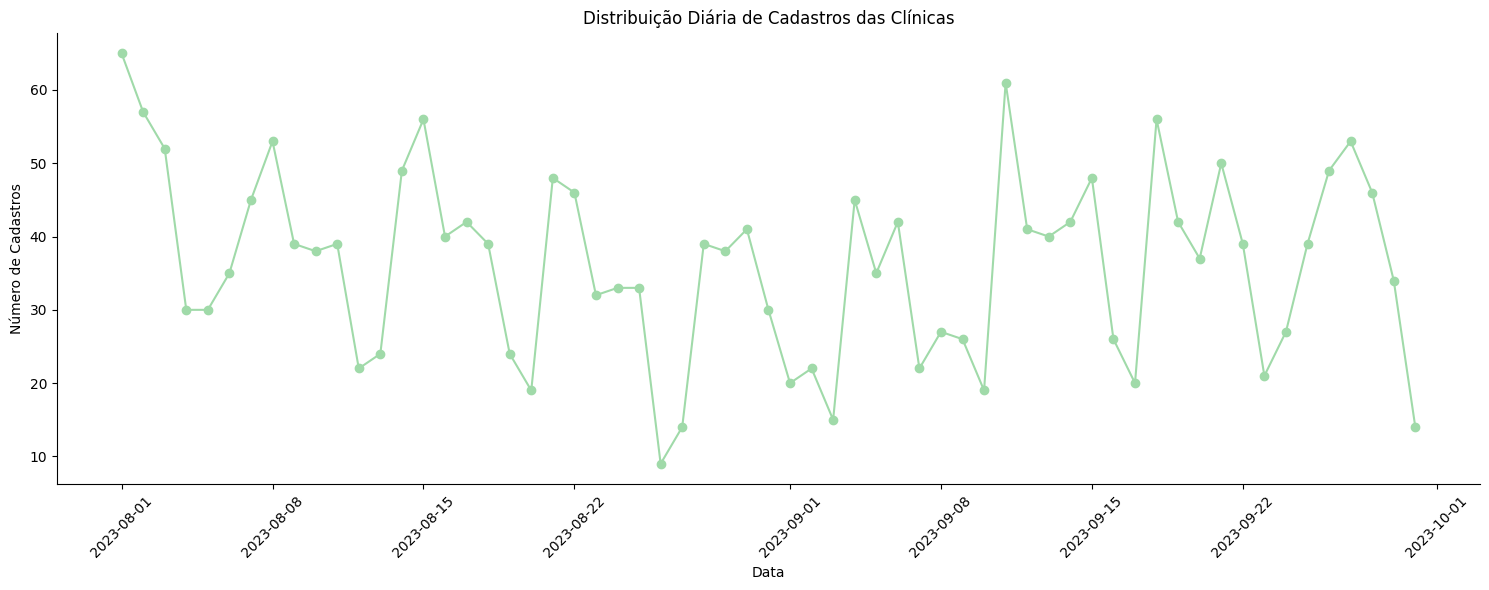

In [8]:
# Criando uma coluna apenas com a data (sem o horário)
clinics_df['CLINIC_CREATED_DATE'] = clinics_df['CLINIC_CREATED_AT'].dt.date

# Contando as frequências de cada data
date_counts = clinics_df['CLINIC_CREATED_DATE'].value_counts().sort_index()

# Plotando a distribuição de datas de cadastro
plt.figure(figsize=(15, 6))
date_counts.plot(kind='line', marker='o', linestyle='-')
plt.title('Distribuição Diária de Cadastros das Clínicas')
plt.xlabel('Data')
plt.ylabel('Número de Cadastros')
plt.grid(False)
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();

A visualização melhorada mostra flutuações no número de cadastros de clínicas ao longo do tempo. É possível identificar dias com picos de cadastros, o que pode estar relacionado a eventos específicos ou esforços de marketing.

Como dito previamente, as clinicas que são grandes redes ou franquias e que usam apenas o Financiamento devem ser removidas de análises sobre conversão de assinaturas. Antes, faremos um deep dive nas colunas BUSINESS_SEGMENTATION e IS_CHAIN_CLINIC.

In [9]:
clinics_df.BUSINESS_SEGMENTATION.value_counts()

Independente             2055
Rede Homologada           143
Independente - Legado      21
Name: BUSINESS_SEGMENTATION, dtype: int64

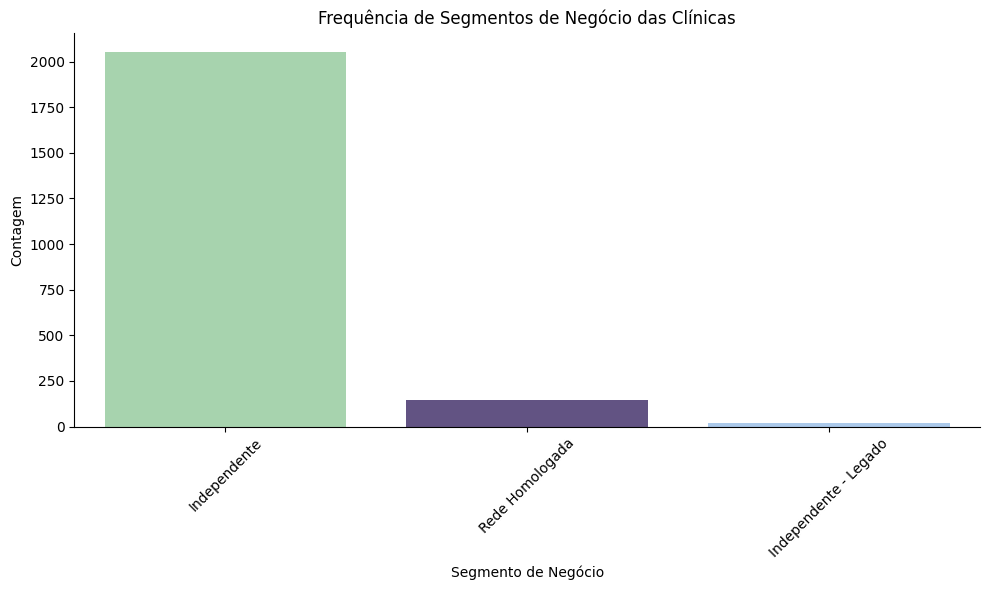

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=clinics_df, x='BUSINESS_SEGMENTATION')
plt.title('Frequência de Segmentos de Negócio das Clínicas')
plt.xlabel('Segmento de Negócio')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();


In [11]:
clinics_df.IS_CHAIN_CLINIC.value_counts()

False    2076
True      143
Name: IS_CHAIN_CLINIC, dtype: int64

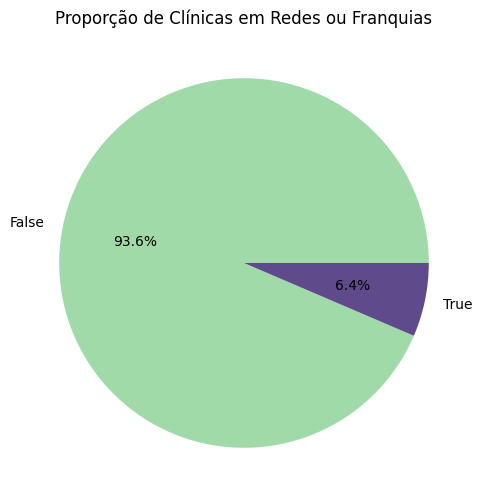

In [12]:
plt.figure(figsize=(10, 6))
clinics_df['IS_CHAIN_CLINIC'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporção de Clínicas em Redes ou Franquias')
plt.ylabel('')
plt.show()


É possível notar que a maioria das clínicas cadastradas são independentes, o que pode refletir o foco da plataforma ou a estratégia de marketing. Os valores são consistentes, temos *143* grandes redes, e o mesmo valor para que usam apenas o financiamento. Esses dados serão removidos na base durante a etapa de modelagem.

Vejamos agora a distribuição das fontes de aquisição.

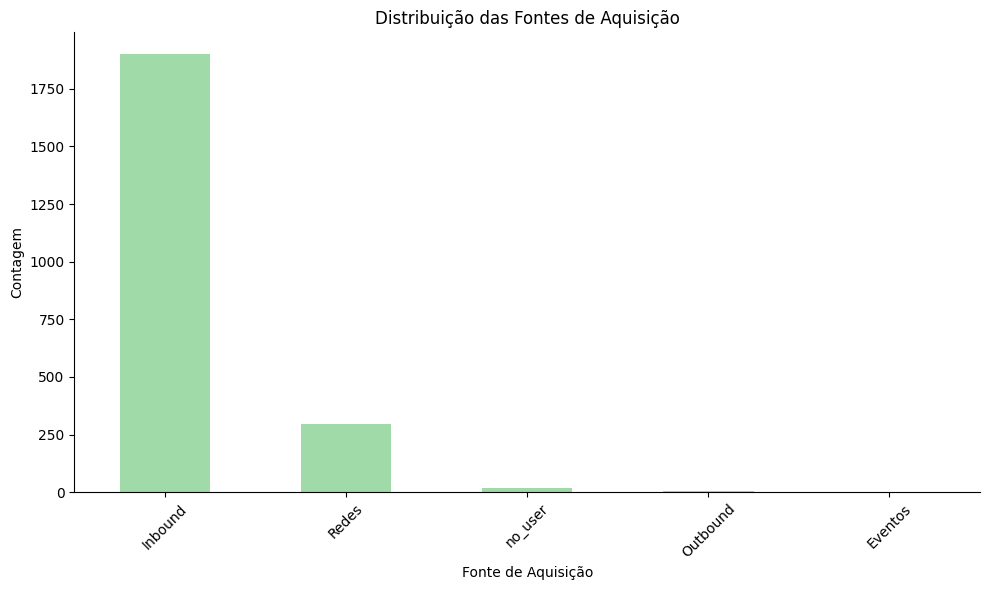

In [13]:
plt.figure(figsize=(10, 6))
clinics_df['FIRST_USER_HUBSPOT_SOURCE'].value_counts().plot(kind='bar')
plt.title('Distribuição das Fontes de Aquisição')
plt.xlabel('Fonte de Aquisição')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();

Algumas fontes de aquisição são claramente mais eficazes do que outras. Isso pode informar estratégias futuras de marketing e aquisição. Vejamos agora o interesse no produto.

In [14]:
clinics_df['INTEREST_CATEGORY_SIGNUP'].value_counts()

Apenas BNPL     881
BNPL e SaaS     665
Apenas SaaS     519
Desconhecido    154
Name: INTEREST_CATEGORY_SIGNUP, dtype: int64

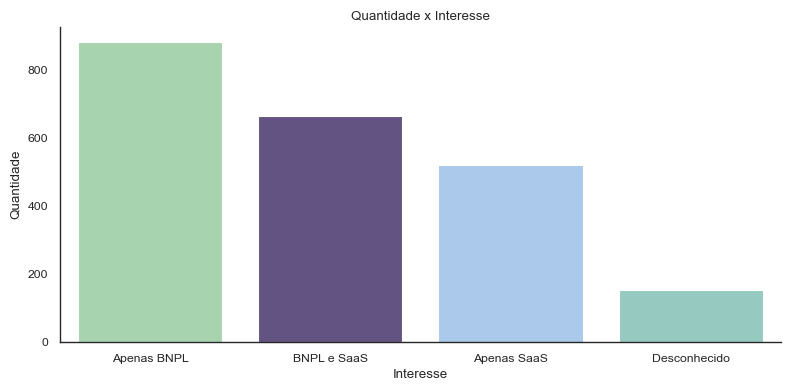

In [15]:
# Plotar um gráfico de barras para ver a distribuição de gênero
sns.set_style("white")
sns.set_context("paper") 


fig, ax = plt.subplots(figsize=(8, 4))
count = clinics_df['INTEREST_CATEGORY_SIGNUP'].value_counts()
sns.countplot(x='INTEREST_CATEGORY_SIGNUP', data=clinics_df, order=count.index)
ax.set_xlabel('Interesse')
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade x Interesse')

sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();

A maioria das pessoas se interessam por apenas BNPL e BNPL e SaaS.

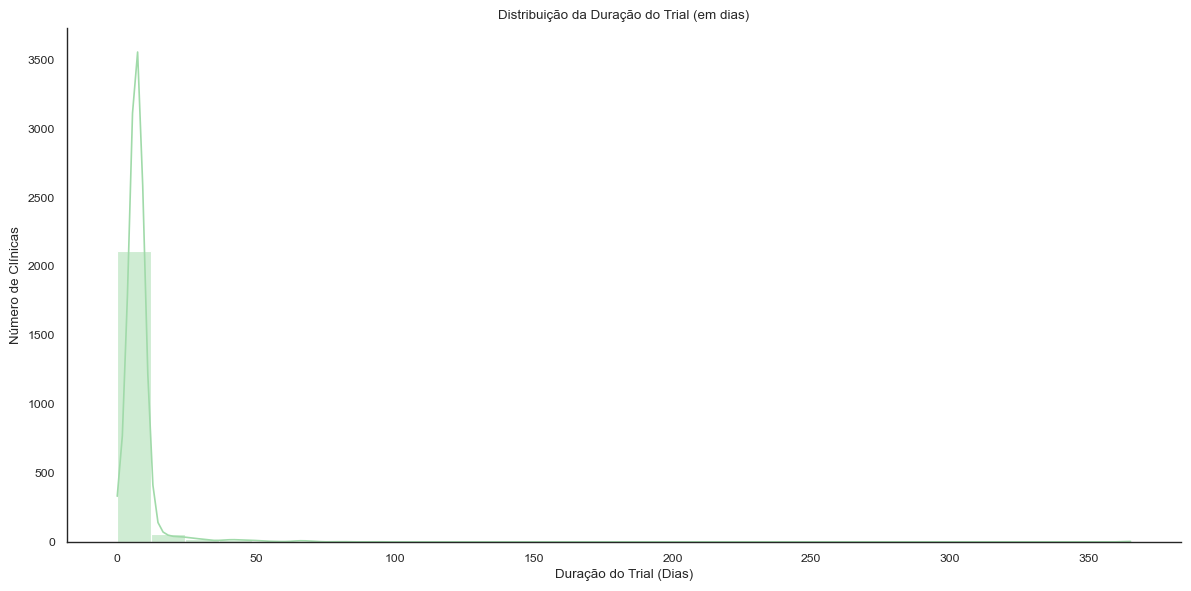

In [16]:
clinics_df['TRIAL_START_DATE'] = pd.to_datetime(clinics_df['TRIAL_START_DATE'])
clinics_df['TRIAL_END_DATE'] = pd.to_datetime(clinics_df['TRIAL_END_DATE'])
clinics_df['TRIAL_DURATION'] = (clinics_df['TRIAL_END_DATE'] - clinics_df['TRIAL_START_DATE']).dt.days

# Agora, plotamos a distribuição da duração do trial
plt.figure(figsize=(12, 6))
sns.histplot(clinics_df['TRIAL_DURATION'].dropna(), bins=30, kde=True)
plt.title('Distribuição da Duração do Trial (em dias)')
plt.xlabel('Duração do Trial (Dias)')
plt.ylabel('Número de Clínicas')
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();

In [17]:
clinics_df.TRIAL_DURATION.describe()

count    2219.000000
mean        8.027490
std        12.392356
min         0.000000
25%         7.000000
50%         7.000000
75%         7.000000
max       365.000000
Name: TRIAL_DURATION, dtype: float64

A duração do período de teste se concentra em torno de uma semana, pois 75% dos dados estão abaixo de 7 dias, podemos verificar esse dado no plot abaixo.

In [18]:
clinics_df['WEEKLY_TRIAL_DURATION'] = pd.cut(clinics_df['TRIAL_DURATION'],
                                               bins=[-1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, float('inf')],
                                               labels=['1ª semana', '2ª semana', '3ª semana', '4ª semana', 
                                                       '5ª semana', '6ª semana', '7ª semana', '8ª semana', 
                                                       '9ª semana', '10ª semana', '11ª semana', '12ª semana', 'Mais de 12 semanas'])

# Visualizando a distribuição dos dados após a segmentação
print(clinics_df['WEEKLY_TRIAL_DURATION'].value_counts())


1ª semana             2065
2ª semana               66
3ª semana               29
4ª semana               18
5ª semana               10
6ª semana                9
7ª semana                6
8ª semana                5
10ª semana               5
Mais de 12 semanas       3
9ª semana                1
11ª semana               1
12ª semana               1
Name: WEEKLY_TRIAL_DURATION, dtype: int64


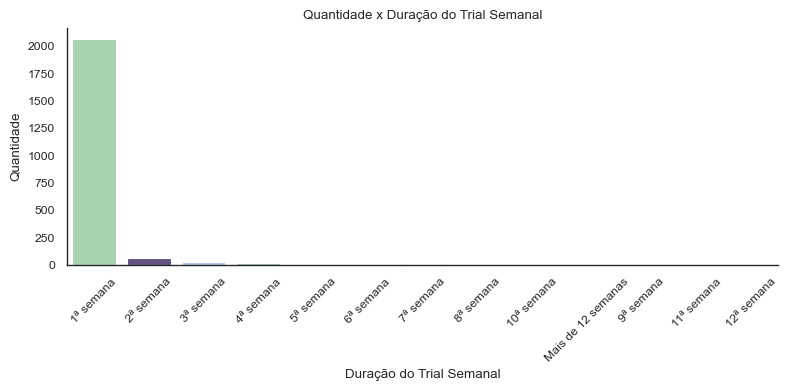

In [19]:
# Plotar um gráfico de barras para ver a distribuição de gênero
sns.set_style("white")
sns.set_context("paper") 


fig, ax = plt.subplots(figsize=(8, 4))
count = clinics_df['WEEKLY_TRIAL_DURATION'].value_counts()
sns.countplot(x='WEEKLY_TRIAL_DURATION', data=clinics_df, order=count.index)
ax.set_xlabel('Duração do Trial Semanal')
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade x Duração do Trial Semanal')
plt.xticks(rotation=45)

sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();

Vejamos também o dia inicial do período de trial.

In [20]:
clinics_df['TRIAL_START_DAY_OF_WEEK'].value_counts()

2    425
1    382
3    381
4    355
5    309
6    194
7    173
Name: TRIAL_START_DAY_OF_WEEK, dtype: int64

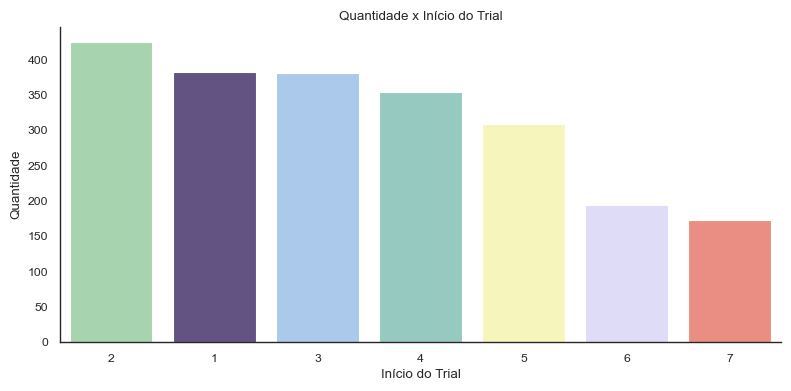

In [21]:
# Plotar um gráfico de barras para ver a distribuição de gênero
sns.set_style("white")
sns.set_context("paper") 


fig, ax = plt.subplots(figsize=(8, 4))
count = clinics_df['TRIAL_START_DAY_OF_WEEK'].value_counts()
sns.countplot(x='TRIAL_START_DAY_OF_WEEK', data=clinics_df, order=count.index)
ax.set_xlabel('Início do Trial')
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade x Início do Trial')

sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();

Certos dias da semana podem ser mais populares para o início do trial, como segunda e terça, o que pode influenciar a programação de suporte e recursos da plataforma.

In [22]:
clinics_df['MARKETING_ATTRIBUITION_CHANNEL_GROUP'].value_counts()

Paid - meta      835
Paid - google    650
Other            548
Organic           99
Other - known     87
Name: MARKETING_ATTRIBUITION_CHANNEL_GROUP, dtype: int64

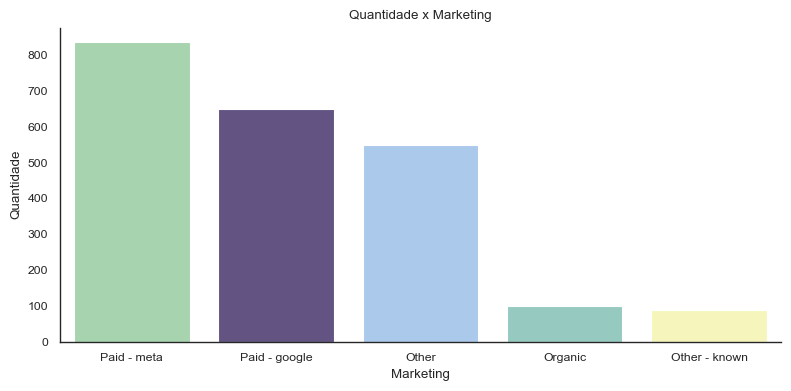

In [23]:
# Plotar um gráfico de barras para ver a distribuição de gênero
sns.set_style("white")
sns.set_context("paper") 


fig, ax = plt.subplots(figsize=(8, 4))
count = clinics_df['MARKETING_ATTRIBUITION_CHANNEL_GROUP'].value_counts()
sns.countplot(x='MARKETING_ATTRIBUITION_CHANNEL_GROUP', data=clinics_df, order=count.index)
ax.set_xlabel('Marketing')
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade x Marketing')

sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();

A visualização mostra quais canais de marketing são mais utilizados, fornecendo insights sobre onde investir recursos de marketing.

Por fim, veremos a distribuição do status de credenciamento das clínicas.

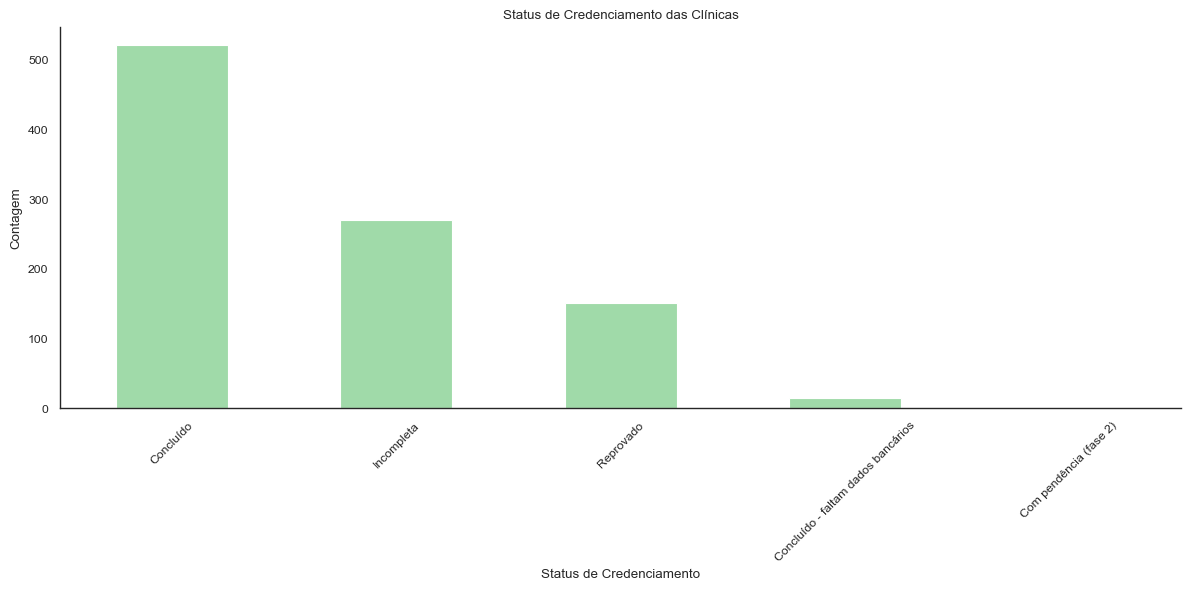

In [24]:
plt.figure(figsize=(12, 6))
clinics_df['CLINIC_ACCREDITATION_STATUS'].value_counts().plot(kind='bar')
plt.title('Status de Credenciamento das Clínicas')
plt.xlabel('Status de Credenciamento')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo

plt.tight_layout()
plt.show();

Pode-se notar que a maioria possui credenciamento concluído.

**Dicionário das variáveis | Base subscriptions**

1. `CLINIC_ID`: Identificador único da clínica associada à assinatura.
2. `STRIPE_SUBSCRIPTION_ID`: Identificador único da assinatura dentro do sistema de pagamento Stripe.
3. `SUBSCRIPTION_START_DATE`: Data de início da assinatura.
4. `SUBSCRIPTION_END_DATE`: Data de término da assinatura (caso tenha sido encerrada).
5. `SUBSCRIPTION_CURRENT_PERIOD_STARTED_AT`: Data de início do período atual de pagamento dentro da assinatura.
6. `SUBSCRIPTION_CURRENT_PERIOD_ENDS_AT`: Data de término do período atual de pagamento dentro da assinatura.
7. `MOST_RECENT_INVOICE_CREATED_AT`: Data de criação da fatura mais recente associada à assinatura.
8. `LAST_PAYMENT_AT`: Data do último pagamento realizado.
9. `CHECKOUT_STATUS`: Status do processo de pagamento/checkout.
10. `SUBSCRIPTION_STATUS`: Status atual da assinatura (por exemplo, ativa, cancelada, etc.).
11. `BILLING_INTERVAL_IN_MONTHS`: Intervalo de faturamento em meses, indicando a frequência com que os pagamentos são feitos.
12. `FIRST_PAYMENT_METHOD_TYPE`: Tipo do método de pagamento utilizado no primeiro pagamento.
13. `FIRST_CARD_BRAND`: Bandeira do cartão utilizado no primeiro pagamento (caso aplicável).
14. `FIRST_PAYMENT_AMOUNT`: Valor do primeiro pagamento.
15. `FIRST_PAYMENT_AMOUNT_OFF`: Desconto aplicado ao valor do primeiro pagamento.
16. `FIRST_PAYMENT_PROMOTION_CODE`: Código de promoção utilizado no primeiro pagamento.
17. `FIRST_PAYMENT_COUPON_ID`: Identificador único do cupom de desconto utilizado no primeiro pagamento.
18. `FIRST_PAYMENT_AMOUNT_OFF_2`: Outro campo indicando um possível desconto aplicado ao valor do primeiro pagamento.

Cada linha na tabela `subscriptions` representa um período específico de assinatura de uma clínica, e se uma clínica cancelar sua assinatura e depois voltar a ser assinante, ela terá múltiplas linhas na tabela, cada uma representando um período distinto de assinatura.

In [25]:
subscriptions_df = pd.read_csv("Arquivos/subscriptions.csv")


# Convertendo colunas de data para datetime
subscriptions_df['SUBSCRIPTION_START_DATE'] = pd.to_datetime(subscriptions_df['SUBSCRIPTION_START_DATE'])
subscriptions_df['SUBSCRIPTION_END_DATE'] = pd.to_datetime(subscriptions_df['SUBSCRIPTION_END_DATE'])
subscriptions_df['SUBSCRIPTION_CURRENT_PERIOD_STARTED_AT'] = pd.to_datetime(subscriptions_df['SUBSCRIPTION_CURRENT_PERIOD_STARTED_AT'])
subscriptions_df['SUBSCRIPTION_CURRENT_PERIOD_ENDS_AT'] = pd.to_datetime(subscriptions_df['SUBSCRIPTION_CURRENT_PERIOD_ENDS_AT'])
subscriptions_df['MOST_RECENT_INVOICE_CREATED_AT'] = pd.to_datetime(subscriptions_df['MOST_RECENT_INVOICE_CREATED_AT'])
subscriptions_df['LAST_PAYMENT_AT'] = pd.to_datetime(subscriptions_df['LAST_PAYMENT_AT'])

In [26]:
print("Entradas: ", subscriptions_df.shape[0])
print("Variáveis: ", subscriptions_df.shape[1])

Entradas:  385
Variáveis:  18


In [27]:
subscriptions_df.head()

,CLINIC_ID,STRIPE_SUBSCRIPTION_ID,SUBSCRIPTION_START_DATE,SUBSCRIPTION_END_DATE,SUBSCRIPTION_CURRENT_PERIOD_STARTED_AT,SUBSCRIPTION_CURRENT_PERIOD_ENDS_AT,MOST_RECENT_INVOICE_CREATED_AT,LAST_PAYMENT_AT,CHECKOUT_STATUS,SUBSCRIPTION_STATUS,BILLING_INTERVAL_IN_MONTHS,FIRST_PAYMENT_METHOD_TYPE,FIRST_CARD_BRAND,FIRST_PAYMENT_AMOUNT,FIRST_PAYMENT_AMOUNT_OFF,FIRST_PAYMENT_PROMOTION_CODE,FIRST_PAYMENT_COUPON_ID,FIRST_PAYMENT_AMOUNT_OFF_2
0,9000,sub_1NaOxzCpjOdJI4gTfqZ2epGB,2023-08-01,2023-10-01,2023-09-01 17:14:51,2023-10-01 17:14:51,2023-09-01 17:16:49,2023-09-01 18:17:14,complete,canceled,1.0,Cartão de Crédito,mastercard,89.9,NaN,NaN,NaN,NaN
1,9032,sub_1Namy7CpjOdJI4gTzrxPLlFg,2023-08-02,NaT,2023-10-02 18:52:35,2023-11-02 18:52:35,2023-10-02 18:53:31,2023-08-09 10:20:45,complete,past_due,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN
2,9105,sub_1NalRdCpjOdJI4gTFRPqMhcv,2023-08-02,NaT,2023-10-02 17:14:57,2023-11-02 17:14:57,2023-10-02 17:16:56,2023-10-02 18:22:04,complete,active,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN
3,9027,sub_1Nb3CECpjOdJI4gTFLOepcZD,2023-08-03,2023-09-03,2023-08-03 12:12:14,2023-09-03 12:12:14,2023-08-03 12:12:14,2023-08-03 12:12:16,complete,canceled,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN
4,9072,sub_1Nb7E2CpjOdJI4gTsIJIy9b1,2023-08-03,2023-09-03,2023-08-03 16:30:22,2023-09-03 16:30:22,2023-08-03 16:30:22,2023-08-03 16:30:24,complete,canceled,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN


In [28]:
subscriptions_df.isnull().sum()/subscriptions_df.shape[0]

CLINIC_ID                                 0.000000
STRIPE_SUBSCRIPTION_ID                    0.000000
SUBSCRIPTION_START_DATE                   0.002597
SUBSCRIPTION_END_DATE                     0.880519
SUBSCRIPTION_CURRENT_PERIOD_STARTED_AT    0.000000
SUBSCRIPTION_CURRENT_PERIOD_ENDS_AT       0.000000
MOST_RECENT_INVOICE_CREATED_AT            0.000000
LAST_PAYMENT_AT                           0.036364
CHECKOUT_STATUS                           0.005195
SUBSCRIPTION_STATUS                       0.005195
BILLING_INTERVAL_IN_MONTHS                0.002597
FIRST_PAYMENT_METHOD_TYPE                 0.002597
FIRST_CARD_BRAND                          0.187013
FIRST_PAYMENT_AMOUNT                      0.002597
FIRST_PAYMENT_AMOUNT_OFF                  1.000000
FIRST_PAYMENT_PROMOTION_CODE              0.823377
FIRST_PAYMENT_COUPON_ID                   0.810390
FIRST_PAYMENT_AMOUNT_OFF_2                1.000000
dtype: float64

Obtivemos um grande número de variáveis com dados nulos, um possível motivo para o mesmo é:
    
1. SUBSCRIPTION_START_DATE (0.26%):
Valores nulos podem indicar registros incompletos ou erros na coleta de dados. Como é uma pequena proporção, pode ser um problema pontual.

2. SUBSCRIPTION_END_DATE (88.05%):
Um alto percentual de nulos nesta coluna sugere que a maioria das assinaturas ainda está ativa. Nulos aqui provavelmente significam que a assinatura não foi encerrada até a data de extração dos dados.

3. LAST_PAYMENT_AT (3.64%):
Nulos podem indicar assinaturas que ainda não realizaram um pagamento ou problemas na captura desses dados.

4. CHECKOUT_STATUS e SUBSCRIPTION_STATUS (ambos 0.52%):
Valores nulos nessas colunas podem ser devido a erros na entrada de dados ou assinaturas em um estado inicial onde o status ainda não foi definido.

5. BILLING_INTERVAL_IN_MONTHS e FIRST_PAYMENT_METHOD_TYPE (ambos 0.26%):
Nulos podem ser resultado de erros de entrada ou falta de informações para algumas assinaturas.

6. FIRST_CARD_BRAND (18.70%):
A ausência de valores aqui pode ocorrer se o primeiro pagamento não foi feito por cartão ou se os dados não foram capturados corretamente.

8. FIRST_PAYMENT_AMOUNT (0.26%):
Semelhante a outras colunas, a falta de dados pode ser devido a erros de entrada ou registros incompletos.

9. FIRST_PAYMENT_AMOUNT_OFF, FIRST_PAYMENT_PROMOTION_CODE, FIRST_PAYMENT_COUPON_ID e FIRST_PAYMENT_AMOUNT_OFF_2:
Altos percentuais de nulos nessas colunas sugerem que a maioria das assinaturas não utilizou promoções, descontos ou cupons. Isso pode ser o padrão normal para a maioria das assinaturas.

Todavia, irei prosseguir a análise univariada, e se necessário, realizar correções.

Começarei verificando a distribuição das datas de início e término das assinaturas para entender padrões temporais.

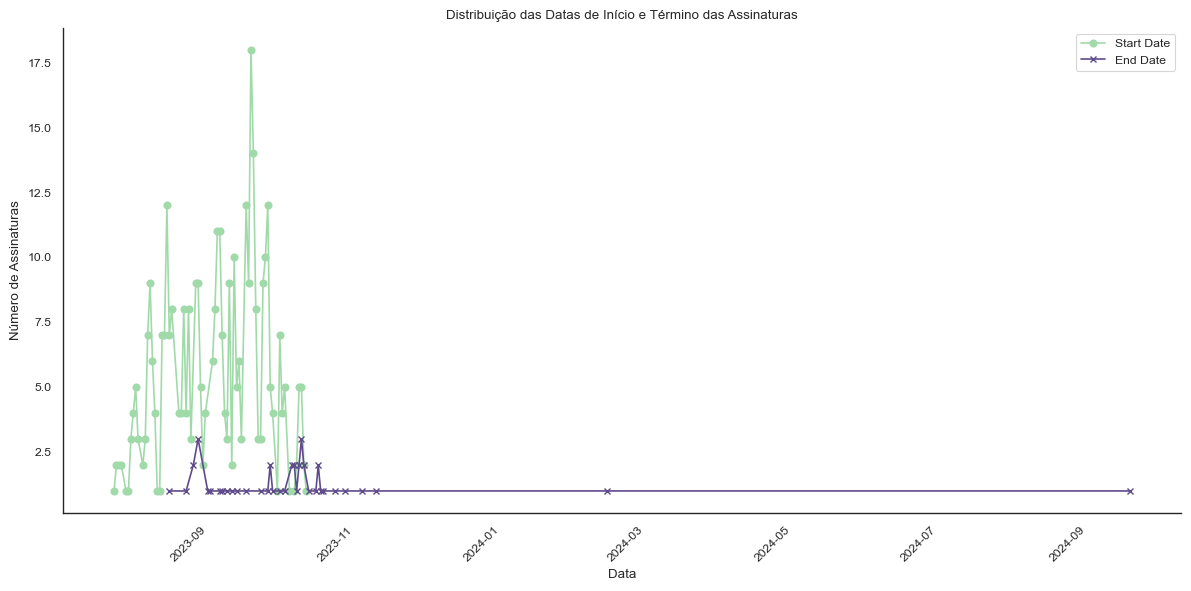

In [29]:
plt.figure(figsize=(12, 6))
subscriptions_df['SUBSCRIPTION_START_DATE'].dt.date.value_counts().sort_index().plot(kind='line', label='Start Date', marker='o')
subscriptions_df['SUBSCRIPTION_END_DATE'].dt.date.value_counts().sort_index().plot(kind='line', label='End Date', marker='x')
plt.title('Distribuição das Datas de Início e Término das Assinaturas')
plt.xlabel('Data')
plt.ylabel('Número de Assinaturas')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show();

Como o período é pequeno, não é possível verificar de maneira clara maior e menor assinaturas.

Verificarei a distribuição do intervalo de faturamento para entender a frequência com que as clínicas são faturadas.

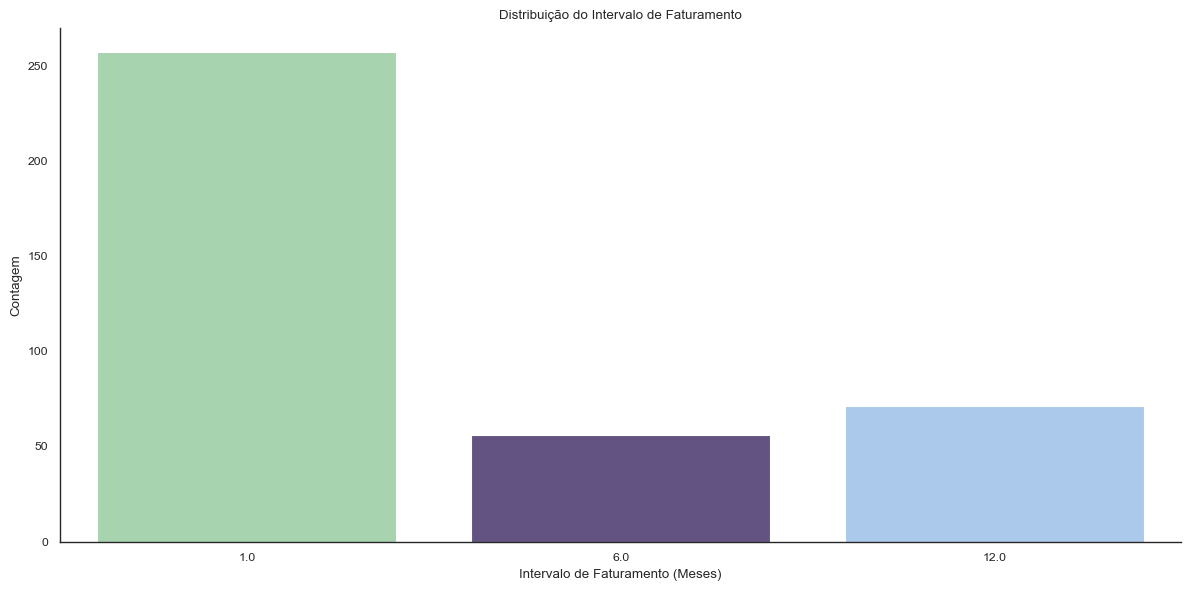

In [30]:
plt.figure(figsize=(12, 6))
sns.countplot(data=subscriptions_df, x='BILLING_INTERVAL_IN_MONTHS')
plt.title('Distribuição do Intervalo de Faturamento')
plt.xlabel('Intervalo de Faturamento (Meses)')
plt.ylabel('Contagem')
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()

Normalmente as clínicas são cobradas com periodicidade de um mês.

Agora irei plotar gráficos úteis para entender as preferências de pagamento das clínicas.

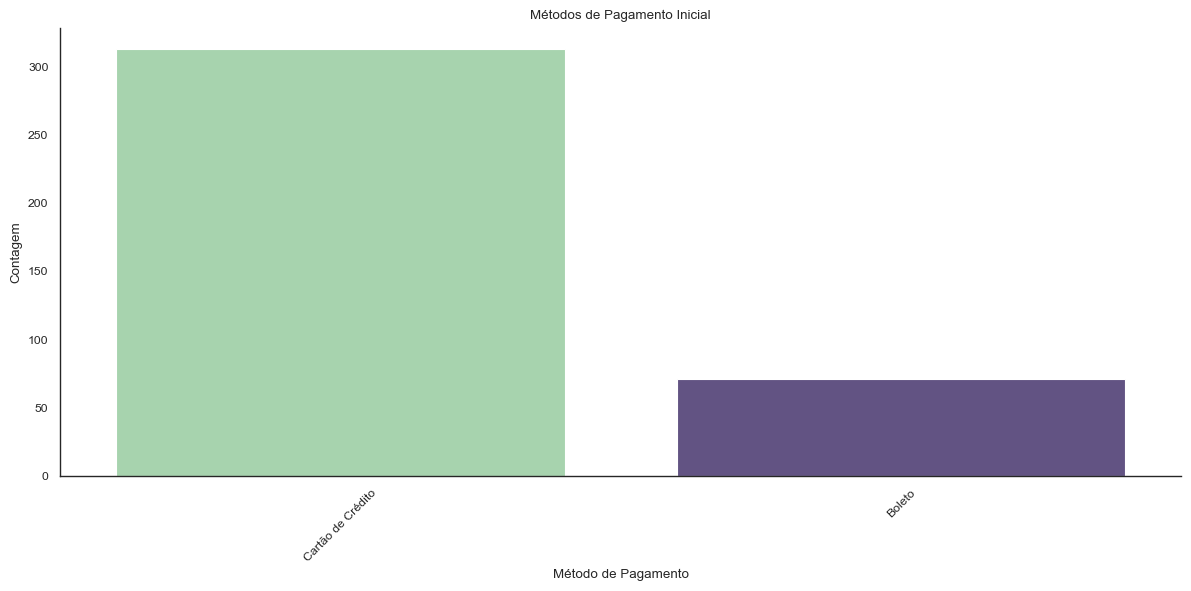

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(data=subscriptions_df, x='FIRST_PAYMENT_METHOD_TYPE')
plt.title('Métodos de Pagamento Inicial')
plt.xlabel('Método de Pagamento')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()

A maioria das clínicas prefere o pagamento por cartão de crédito

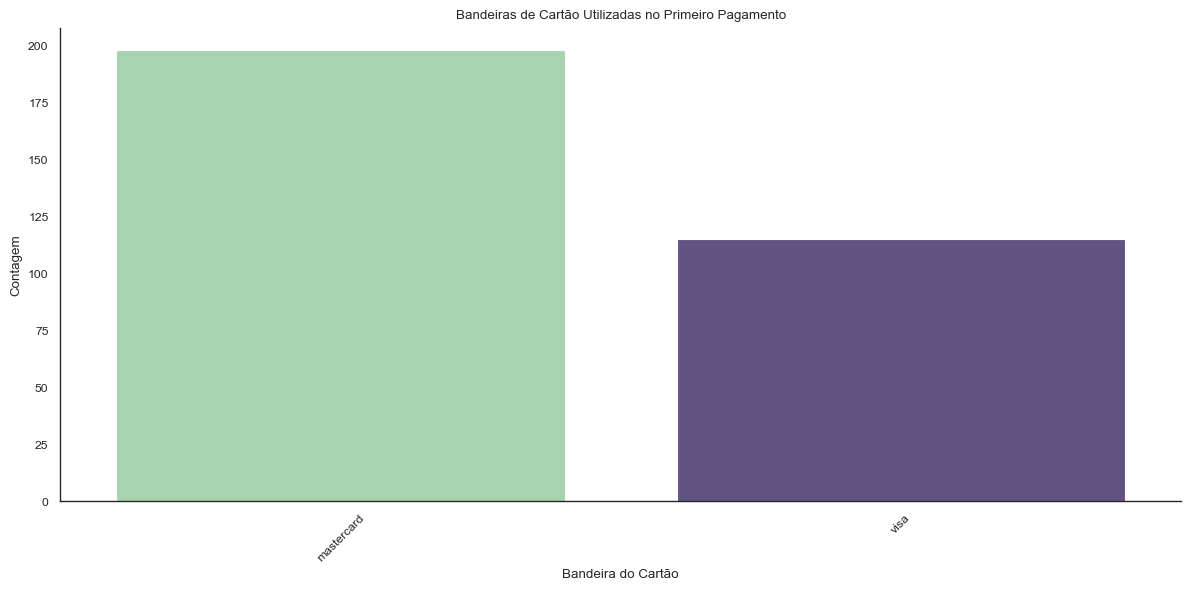

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(data=subscriptions_df, x='FIRST_CARD_BRAND')
plt.title('Bandeiras de Cartão Utilizadas no Primeiro Pagamento')
plt.xlabel('Bandeira do Cartão')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()

A bandeira mais utilizada é a mastercard

Irei plotar a  distribuição dos valores do primeiro pagamento feito pelas clínicas, fornecendo insights sobre a estrutura de preços e a acessibilidade da plataforma.

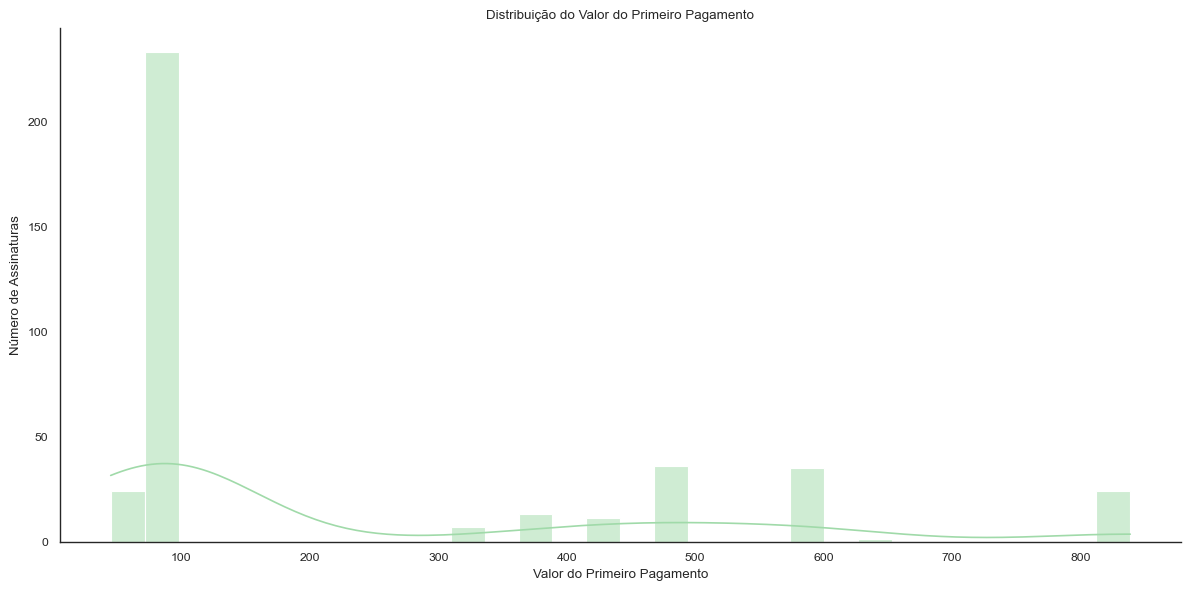

In [33]:
plt.figure(figsize=(12, 6))
sns.histplot(subscriptions_df['FIRST_PAYMENT_AMOUNT'].dropna(), bins=30, kde=True)
plt.title('Distribuição do Valor do Primeiro Pagamento')
plt.xlabel('Valor do Primeiro Pagamento')
plt.ylabel('Número de Assinaturas')
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()


In [34]:
subscriptions_df['FIRST_PAYMENT_AMOUNT'].describe()

count    384.000000
mean     241.678958
std      238.445196
min       44.950000
25%       89.900000
50%       89.900000
75%      434.400000
max      838.800000
Name: FIRST_PAYMENT_AMOUNT, dtype: float64

O valor mínimo de primeiro pagamento é 44 reais, e a mediana se concentra em 89 reais. A média é bem maior, o que sugere alguns outliers e uma distribuição assimétrica.

Por fim, irei mostrar a frequência dos diferentes status de checkout, o que pode indicar a eficiência do processo de finalização da compra ou possíveis pontos de atrito.

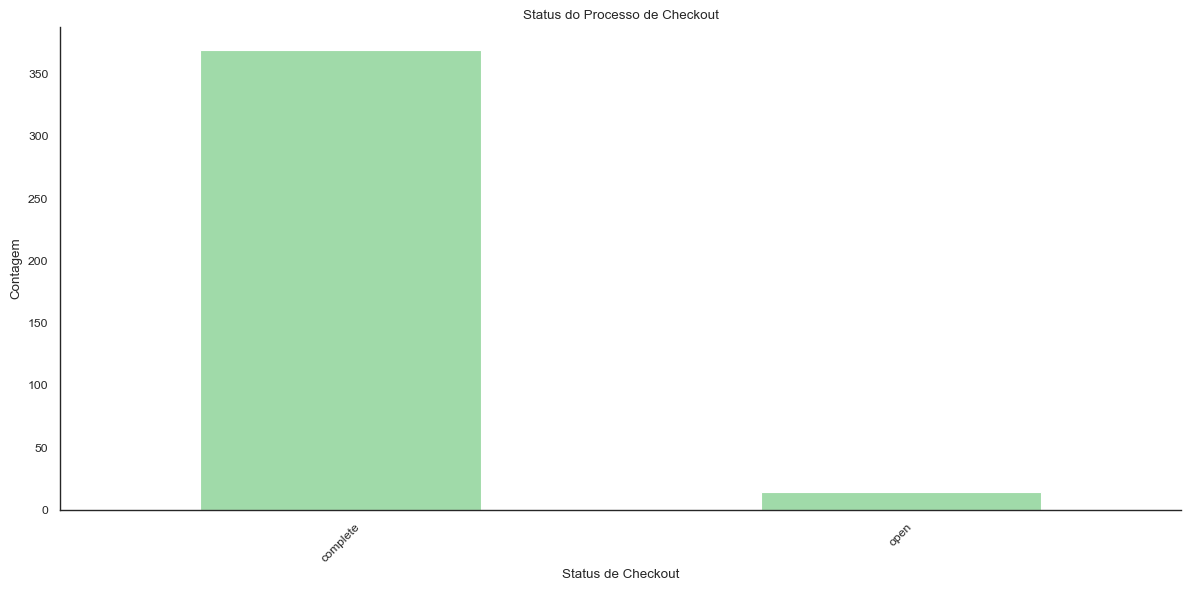

In [35]:

plt.figure(figsize=(12, 6))
subscriptions_df['CHECKOUT_STATUS'].value_counts().plot(kind='bar')
plt.title('Status do Processo de Checkout')
plt.xlabel('Status de Checkout')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()

A maioria do processo de checkout está completo.

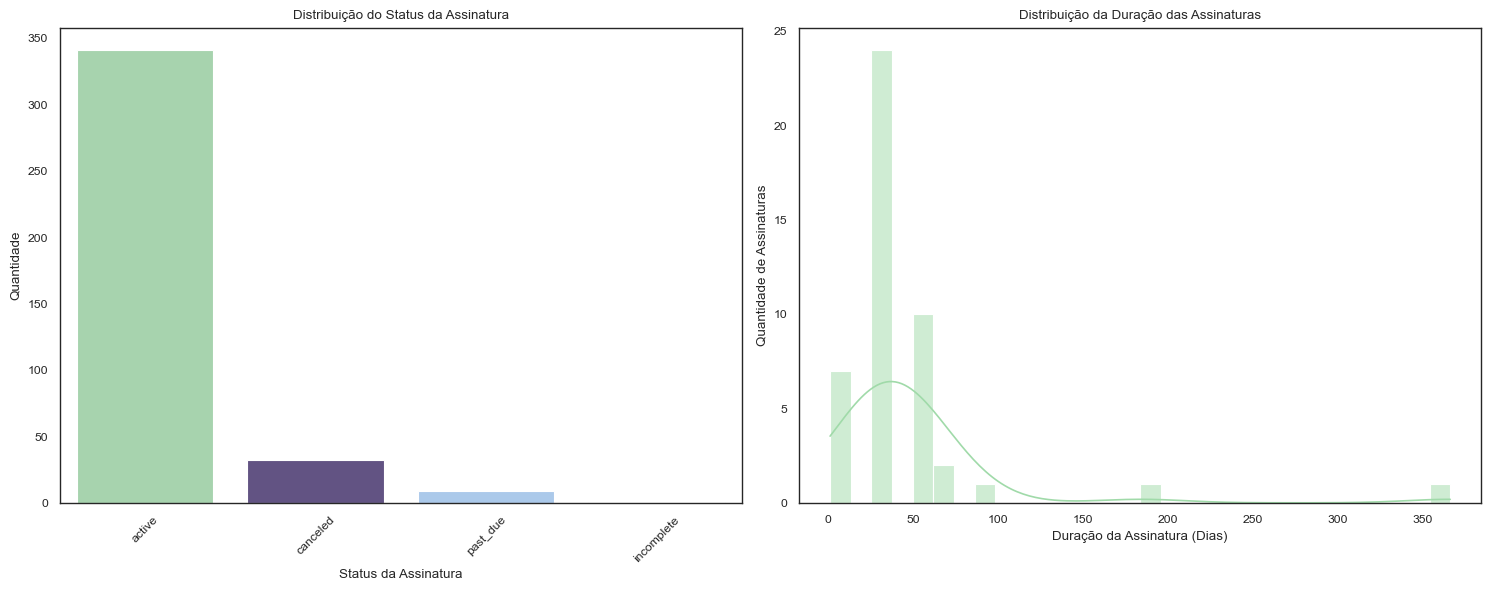

In [36]:
# Calculando a duração da assinatura em dias
subscriptions_df['SUBSCRIPTION_DURATION'] = (subscriptions_df['SUBSCRIPTION_END_DATE'] - subscriptions_df['SUBSCRIPTION_START_DATE']).dt.days

# Análise do Status da Assinatura
subscription_status_count = subscriptions_df['SUBSCRIPTION_STATUS'].value_counts()

# Distribuição da Duração das Assinaturas
plt.figure(figsize=(15, 6))

# Gráfico para Status da Assinatura
plt.subplot(1, 2, 1)
sns.barplot(x=subscription_status_count.index, y=subscription_status_count.values)
plt.title('Distribuição do Status da Assinatura')
plt.xlabel('Status da Assinatura')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)

# Gráfico para Duração das Assinaturas
plt.subplot(1, 2, 2)
sns.histplot(subscriptions_df['SUBSCRIPTION_DURATION'].dropna(), bins=30, kde=True)
plt.title('Distribuição da Duração das Assinaturas')
plt.xlabel('Duração da Assinatura (Dias)')
plt.ylabel('Quantidade de Assinaturas')

plt.tight_layout()
plt.show()

**Dicionário das variáveis | Base activity**

1. `CLINIC_ID`: Identificador único da clínica associada à atividade.
2. `ACTIVITY_AT`: Data e horário em que a atividade foi realizada.
3. `ACTIVITY_TYPE`: Tipo da atividade realizada.
4. `FEATURE`: Característica ou funcionalidade específica do produto com a qual a atividade está relacionada.
5. `MODULE`: Módulo do sistema ou parte do produto em que a atividade ocorreu.
6. `ANALYTICS_DOMAIN`: Domínio analítico, representando uma categorização mais ampla da atividade para fins analíticos.
7. `IS_TRANSACTION`: Indica se a atividade é uma transação (envolve movimentação de dinheiro ou valores).
8. `IS_BNPL_ACTIVITY`: Indica se a atividade está relacionada a "Buy Now, Pay Later" (Compre agora, pague depois).
9. `IS_VALID_ACTIVITY`: Indica se a atividade é considerada válida. Algumas métricas são calculadas apenas considerando atividades válidas.
10. `IS_DELETION_ACTIVITY`: Indica se a atividade envolve a exclusão de dados ou configurações.
11. `IS_MANAGEMENT_ACTIVITY`: Indica se a atividade está relacionada à gestão ou administração da clínica ou do sistema.
12. `IS_FINANCE_ACTIVITY`: Indica se a atividade está relacionada a finanças ou atividades financeiras.

É importante observar que essa tabela só contém atividades realizadas durante o período de trial das clínicas, o que pode ser útil para análises específicas desse período inicial de uso do produto pela clínica.

In [37]:
activity_df = pd.read_csv("Arquivos/activity.csv")

activity_df['ACTIVITY_AT'] = pd.to_datetime(activity_df['ACTIVITY_AT'])


In [38]:
activity_df.head()

,CLINIC_ID,ACTIVITY_AT,ACTIVITY_TYPE,FEATURE,MODULE,ANALYTICS_DOMAIN,IS_TRANSACTION,IS_BNPL_ACTIVITY,IS_VALID_ACTIVITY,IS_DELETION_ACTIVITY,IS_MANAGEMENT_ACTIVITY,IS_FINANCE_ACTIVITY
0,9825,2023-08-24 18:46:47.733,patient_discarded,patient_management,patient,patient,False,False,True,True,True,False
1,9984,2023-08-24 19:41:43.497,patient_created,patient_management,patient,patient,False,False,False,False,True,False
2,9984,2023-08-24 19:41:44.037,time_slot_created,scheduling,schedule,scheduling,False,False,True,False,True,False
3,9984,2023-08-24 19:51:20.451,patient_created,patient_management,patient,patient,False,False,False,False,True,False
4,9984,2023-08-24 19:51:46.663,time_slot_created,scheduling,schedule,scheduling,False,False,True,False,True,False


In [39]:
activity_df.isnull().sum()/activity_df.shape[0]

CLINIC_ID                 0.0
ACTIVITY_AT               0.0
ACTIVITY_TYPE             0.0
FEATURE                   0.0
MODULE                    0.0
ANALYTICS_DOMAIN          0.0
IS_TRANSACTION            0.0
IS_BNPL_ACTIVITY          0.0
IS_VALID_ACTIVITY         0.0
IS_DELETION_ACTIVITY      0.0
IS_MANAGEMENT_ACTIVITY    0.0
IS_FINANCE_ACTIVITY       0.0
dtype: float64

Na tabela activity, não há valores ausentes.

Primeiramente, iremos observar  frequência das atividades ao longo do tempo, permitindo identificar padrões ou picos de atividade, que podem estar relacionados a eventos específicos ou características do período de trial.

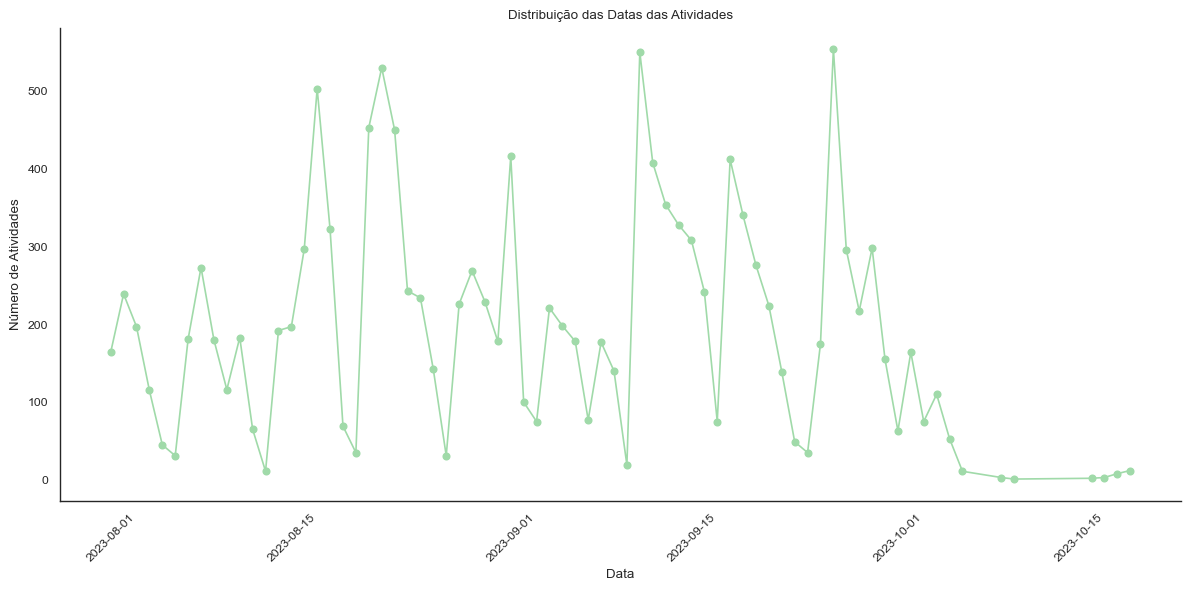

In [40]:
plt.figure(figsize=(12, 6))
activity_df['ACTIVITY_AT'].dt.date.value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Distribuição das Datas das Atividades')
plt.xlabel('Data')
plt.ylabel('Número de Atividades')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()


Não é possível notar um padrão da distribuição das datas por atividade. Verficaremos quais tipos de atividades são mais comuns, indicando as funcionalidades ou aspectos do produto que são mais utilizados ou que demandam mais atenção das clínicas.

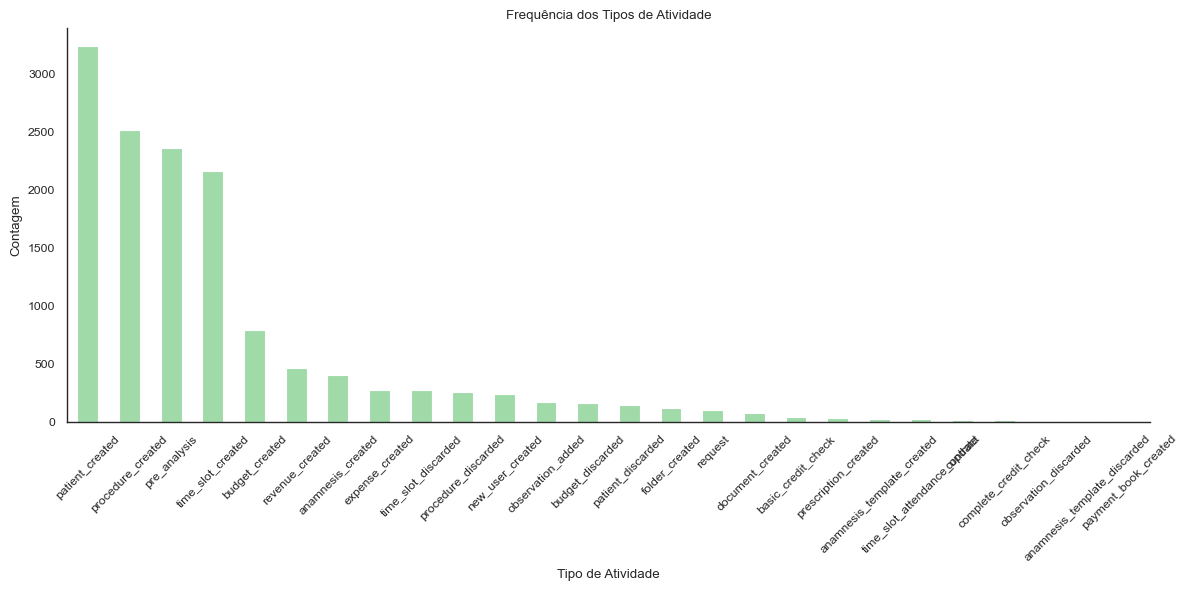

In [41]:
plt.figure(figsize=(12, 6))
activity_df['ACTIVITY_TYPE'].value_counts().plot(kind='bar')
plt.title('Frequência dos Tipos de Atividade')
plt.xlabel('Tipo de Atividade')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()


Apresentaremos as funcionalidades mais utilizadas e atraentes no produto.



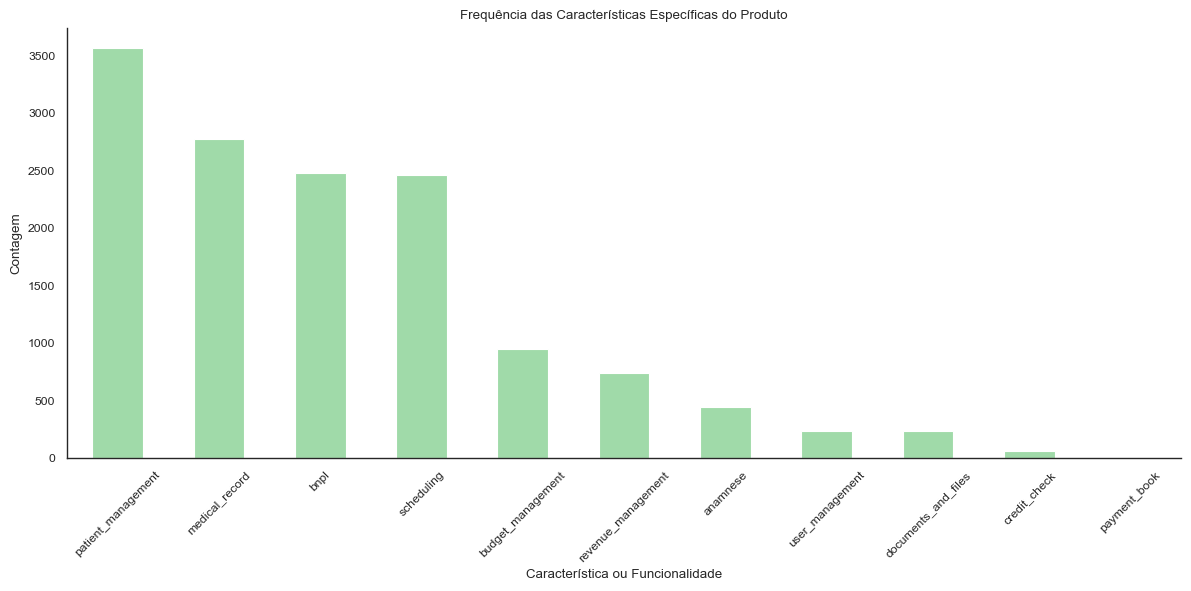

In [42]:
plt.figure(figsize=(12, 6))
activity_df['FEATURE'].value_counts().plot(kind='bar')
plt.title('Frequência das Características Específicas do Produto')
plt.xlabel('Característica ou Funcionalidade')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()


As funcionalidades mais utilizadas são `patient_management`, `medical_record` e `bnlp`.

Vejamos agora a distribuição do uso dos diferentes módulos do sistema, indicando as áreas do produto que são mais acessadas ou utilizadas pelas clínicas.

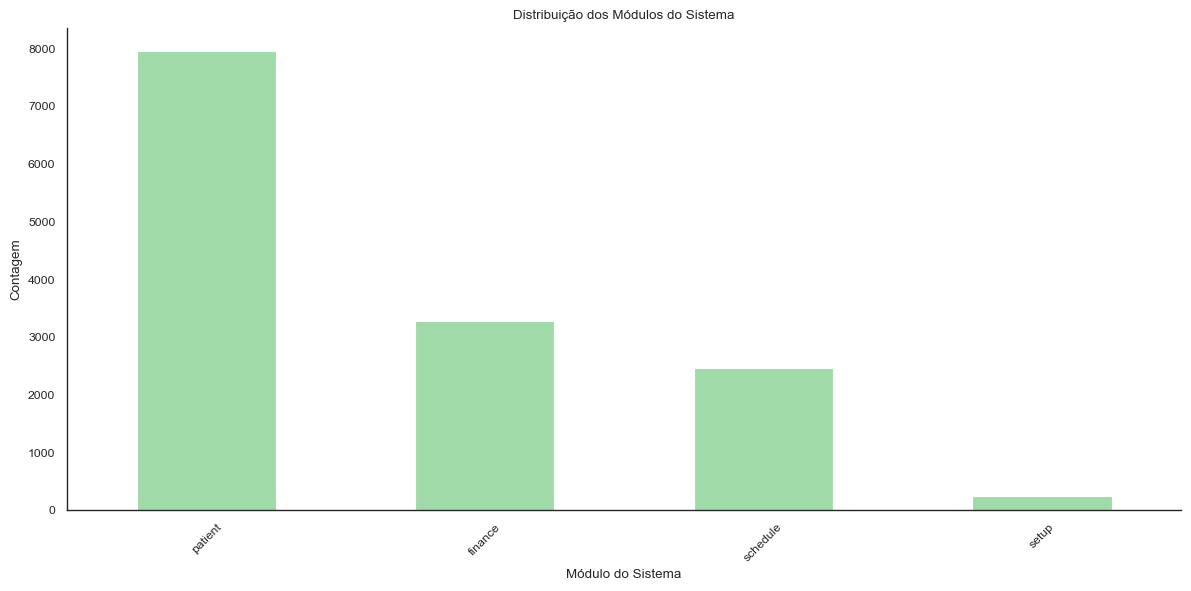

In [43]:
plt.figure(figsize=(12, 6))
activity_df['MODULE'].value_counts().plot(kind='bar')
plt.title('Distribuição dos Módulos do Sistema')
plt.xlabel('Módulo do Sistema')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()

Vejamos também os domínios analíticos mais frequentes, que podem refletir áreas de interesse ou foco das clínicas durante o período de trial.

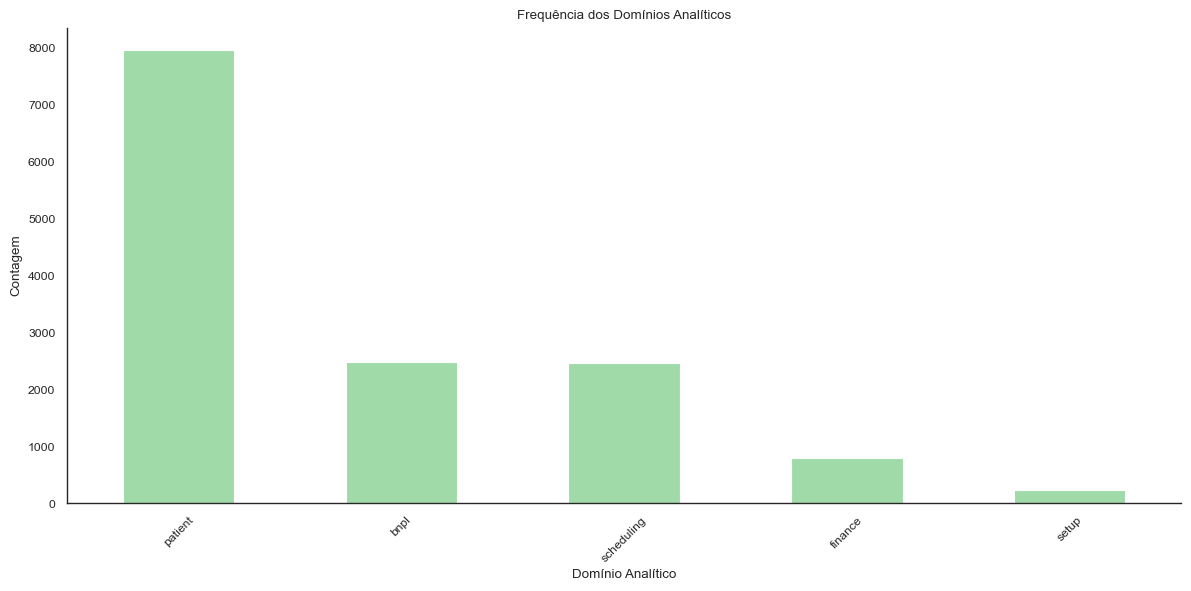

In [44]:
plt.figure(figsize=(12, 6))
activity_df['ANALYTICS_DOMAIN'].value_counts().plot(kind='bar')
plt.title('Frequência dos Domínios Analíticos')
plt.xlabel('Domínio Analítico')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()

Após obter maior intuição sobre os dados de cada base, seguiremos para a análise multivariada, fornecendo o primeiro entregável: Modelagem de dados sobre a entrada da clínica e seu período de trial até a conversão.

## Modelagem de Dados & Dashboard

Uma possível solução para a modelagem é a construção de um Data Warehouse, onde levaremos apenas as informações principais.
Um Data Warehouse (DW) é uma estratégia para armazenar informações de diferentes sistemas para análise e tomada de decisões em negócios, oferecendo suporte a transações históricas.

- Tabela Fato: Contém informações sobre o assunto de interesse e é normalmente uma tabela normalizada com grande volume de dados.
- Dimensões: São tabelas não normalizadas com pequeno volume que apoiam a estruturação da tabela fato.

Abaixo, veremos como está disposto os dados atualmente nas tabelas fornecidas.

<img src = "Arquivos/modelagem.png" width = "70%">

Já modelando com o DW, chegaríamos na seguinte solução.

<img src = "Arquivos/dw.png" width = "70%">

Contudo, como a implementação de um DW pode ser demasiadamente complexa, seguiremos o desafio utilizando agregamento e agrupações em Python.

Para finalizar o desafio proposto, iremos realizar:

* Uniões dos Dados: União entre clinics e subscriptions e activity.
* Criação de Variáveis Relevantes: Criaremos variáveis derivadas que possam ser úteis para análises, como o tempo desde a criação da clínica até o início do trial ou a conversão em assinatura.
* Remoção das clínicas que são grandes redes ou franquias e que usam apenas o Financiamento.
* Será considerado clínica convertida se a data de início da assinatura for após o fim do trial.

In [45]:
# Unindo activity.csv com clinics.csv
activity_clinics_df = pd.merge(activity_df, clinics_df, on="CLINIC_ID", how="left")

# Unindo o resultado com subscriptions.csv
data = pd.merge(activity_clinics_df, subscriptions_df, on="CLINIC_ID", how="left")

# Filtrando clínicas que não usam apenas o Financiamento 
data = data[~data['IS_CHAIN_CLINIC']]

columns_to_drop = ['FIRST_PAYMENT_AMOUNT_OFF', 'FIRST_PAYMENT_AMOUNT_OFF_2']
data_cleaned = data.drop(columns=columns_to_drop)

# Convertendo colunas de data para o formato datetime
date_columns = ['ACTIVITY_AT', 'CLINIC_CREATED_AT', 'TRIAL_START_DATE', 'TRIAL_END_DATE']
for col in date_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col])


In [46]:
data_cleaned.shape

(12421, 62)

In [47]:
# Exportar os dados em um arquivo csv
data_cleaned.to_csv("modelodados.csv")

Estrutura de Dados: A tabela tem 12.421 dados com 62 colunas. Algumas colunas têm valores nulos, o que precisaremos considerar durante a análise.

Para compreender melhor a eficácia e o impacto do período de trial na aquisição e retenção de clientes, cinco Key Performance Indicators (KPIs) foram estabelecidos. Cada KPI fornece insights valiosos sobre diferentes aspectos do comportamento e das decisões das clínicas durante e após o período de trial. Vamos detalhar cada um deles:

### KPI 1: Taxa de Conversão de Trial para Assinatura
- **Descrição**: Mede a proporção de clínicas que, após passarem pelo período de trial, decidiram se converter em assinantes pagos.
- **Importância**: Este KPI é crucial para avaliar a eficácia do trial em persuadir clínicas a se tornarem clientes pagos. Uma taxa de conversão alta indica que o período de trial é eficiente em demonstrar o valor do serviço, incentivando as clínicas a fazerem uma assinatura.

### KPI 2: Atividades Médias por Clínica durante o Trial
- **Descrição**: Calcula a média de atividades válidas realizadas por clínica durante o período de trial.
- **Importância**: Este KPI oferece insights sobre o nível de engajamento e interação das clínicas com o produto durante o trial. Um número maior de atividades sugere um alto envolvimento, o que pode ser um indicador positivo de interesse e satisfação com o produto.

### KPI 3: Duração Média do Trial
- **Descrição**: Determina a duração média do período de trial entre todas as clínicas.
- **Importância**: Compreender a duração média do trial ajuda a avaliar se o período fornecido é adequado para que as clínicas experimentem e avaliem o produto. Uma duração otimizada pode ser fundamental para maximizar a conversão sem prolongar desnecessariamente o período sem receita.

### KPI 4: Taxa de Retenção de Assinaturas
- **Descrição**: Mede a proporção de assinaturas que foram renovadas após o primeiro ciclo de cobrança.
- **Importância**: Este KPI é essencial para entender a retenção de clientes a longo prazo. Uma alta taxa de retenção indica que os clientes estão satisfeitos com o serviço e veem valor contínuo em permanecer como assinantes, o que é vital para a sustentabilidade e o crescimento da receita.

### KPI 5: Taxa de Ativação de Assinaturas Pós-Trial
- **Descrição**: Calcula a proporção de clínicas que ativaram uma assinatura imediatamente após o término do trial.
- **Importância**: Este KPI destaca a eficácia do trial em motivar uma decisão de compra imediata. Uma alta taxa de ativação pós-trial sugere que o trial é eficaz em demonstrar o valor do produto de forma convincente, levando a uma transição suave de potenciais clientes para clientes pagos.

### KPI 6: Churn de Pessoas com o Trial vs Sem Trial
- **Descrição**:Este KPI mede e compara a taxa de churn (desistência) entre duas categorias distintas de clínicas: aquelas que participaram de um período de trial e aquelas que não participaram. O churn é identificado por clínicas que, em algum momento após o início do serviço, deixaram de ser clientes ativos.
- **Importância**: : Este KPI é fundamental para entender o impacto do período de trial na decisão das clínicas de continuar ou não com o serviço. Uma alta taxa de churn entre as clínicas que participaram do trial pode indicar problemas na adequação do trial às necessidades dos clientes, falhas na comunicação do valor do serviço, ou desalinhamento entre as expectativas geradas durante o trial e a experiência real com o produto ou serviço.
 


Cada um desses KPIs oferece uma perspectiva única e valiosa sobre o desempenho do período de trial, ajudando a identificar áreas de sucesso e oportunidades de melhoria na jornada do cliente, desde a experimentação inicial até a adoção e retenção a longo prazo.

In [48]:
# Convertendo strings de data para datetime
data_cleaned['ACTIVITY_AT'] = pd.to_datetime(data_cleaned['ACTIVITY_AT'])
data_cleaned['TRIAL_START_DATE'] = pd.to_datetime(data_cleaned['TRIAL_START_DATE'])
data_cleaned['TRIAL_END_DATE'] = pd.to_datetime(data_cleaned['TRIAL_END_DATE'])
data_cleaned['SUBSCRIPTION_START_DATE'] = pd.to_datetime(data_cleaned['SUBSCRIPTION_START_DATE'])
data_cleaned['SUBSCRIPTION_END_DATE'] = pd.to_datetime(data_cleaned['SUBSCRIPTION_END_DATE'])
active_subscriptions = data_cleaned[data_cleaned['SUBSCRIPTION_STATUS'] == 'active']


# KPI 1: Taxa de Conversão de Trial para Assinatura
converted_clinics = data_cleaned[data_cleaned['SUBSCRIPTION_STATUS'] == 'active']
conversion_rate = len(converted_clinics['CLINIC_ID'].unique()) / len(data_cleaned['CLINIC_ID'].unique())

# KPI 2: Atividades Médias por Clínica durante o Trial
valid_activities = data_cleaned[data_cleaned['IS_VALID_ACTIVITY']]
activities_per_clinic = valid_activities.groupby('CLINIC_ID').size()
average_activities_per_clinic = activities_per_clinic.mean()

# KPI 3: Duração Média do Trial
data_cleaned['TRIAL_DURATION'] = (data_cleaned['TRIAL_END_DATE'] - data_cleaned['TRIAL_START_DATE']).dt.days
average_trial_duration = data_cleaned['TRIAL_DURATION'].mean()

# KPI 4: Taxa de Retenção de Assinaturas
renewed_subscriptions = active_subscriptions[active_subscriptions['SUBSCRIPTION_DURATION'] > active_subscriptions['BILLING_INTERVAL_IN_MONTHS']]
retention_rate = len(renewed_subscriptions) / len(active_subscriptions)

# KPI 5: Taxa de Ativação de Assinaturas Pós-Trial
post_trial_activations = data_cleaned[(data_cleaned['SUBSCRIPTION_START_DATE'] > data_cleaned['TRIAL_END_DATE']) & (data_cleaned['SUBSCRIPTION_STATUS'] == 'active')]
activation_rate_post_trial = len(post_trial_activations['CLINIC_ID'].unique()) / len(data_cleaned['CLINIC_ID'].unique())


#KPI 6: Taxa de Churn para clínicas com Trial vs Sem Trial

# Identificando clínicas que participaram do trial
clinics_with_trial = data_cleaned[data_cleaned['TRIAL_START_DATE'].notna()]['CLINIC_ID'].unique()

# Identificando clínicas que nunca participaram do trial
clinics_without_trial = data_cleaned[~data_cleaned['CLINIC_ID'].isin(clinics_with_trial)]['CLINIC_ID'].unique()

# Calculando o churn (clínicas que abandonaram o serviço)
# Churn é identificado por clínicas que não estão mais ativas
churned_clinics = data_cleaned[data_cleaned['SUBSCRIPTION_STATUS'] != 'active']['CLINIC_ID'].unique()

# Calculando churn para clínicas com e sem trial
churn_with_trial = len([clinic for clinic in churned_clinics if clinic in clinics_with_trial])
churn_without_trial = len([clinic for clinic in churned_clinics if clinic in clinics_without_trial])

# Taxa de churn para clínicas com e sem trial
total_clinics_with_trial = len(clinics_with_trial)
total_clinics_without_trial = len(clinics_without_trial)

churn_rate_with_trial = churn_with_trial / total_clinics_with_trial if total_clinics_with_trial > 0 else 0
churn_rate_without_trial = churn_without_trial / total_clinics_without_trial if total_clinics_without_trial > 0 else 0



conversion_rate, average_activities_per_clinic, average_trial_duration, retention_rate, activation_rate_post_trial, churn_rate_with_trial, churn_rate_without_trial


(0.2451678535096643,
 9.573598130841122,
 8.673697769905806,
 0.11348684210526316,
 0.0844354018311292,
 0.7548321464903357,
 0)

Os resultados obtidos para cada KPI oferecem insights valiosos sobre a eficácia do período de trial e a subsequente conversão e retenção de clientes. Vamos analisar cada um dos KPIs e suas implicações:

### KPI 1: Taxa de Conversão de Trial para Assinatura - 24.52%
- **Interpretação**: Cerca de 24,5% das clínicas que passaram pelo período de trial optaram por se tornar assinantes pagos.
- **Oportunidades de Melhoria**: Este número indica um potencial de conversão razoável, mas há espaço para melhorias. Estratégias como otimização do período de trial, personalização da experiência durante o trial, e um reforço nas comunicações sobre os benefícios e características do serviço podem ajudar a aumentar esta taxa.

### KPI 2: Atividades Médias por Clínica durante o Trial - 9.57
- **Interpretação**: Em média, cada clínica realizou aproximadamente 9,6 atividades válidas durante o trial.
- **Oportunidades de Melhoria**: Aumentar o engajamento durante o trial é crucial. Implementar gamificação, tutoriais interativos, e suporte proativo podem encorajar mais interação. Mais atividades geralmente indicam maior familiaridade e valor percebido, o que pode leutar a uma maior taxa de conversão.

### KPI 3: Duração Média do Trial - 8.67 dias
- **Interpretação**: O período médio de trial é de aproximadamente 8,7 dias.
- **Oportunidades de Melhoria**: Avaliar se este período é suficiente para que as clínicas explorem adequadamente o serviço é fundamental. Uma pesquisa com as clínicas que não converteram pode revelar se elas precisariam de mais tempo ou de mais recursos durante o trial.

### KPI 4: Taxa de Retenção de Assinaturas - 11.35%
- **Interpretação**: Apenas cerca de 11,4% das assinaturas foram renovadas após o primeiro ciclo de cobrança.
- **Oportunidades de Melhoria**: Esta é uma área crítica que necessita de atenção imediata. A melhoria no suporte ao cliente, feedback constante, atualizações regulares do produto e personalização dos serviços podem ajudar a aumentar a retenção de clientes.

### KPI 5: Taxa de Ativação de Assinaturas Pós-Trial - 8.44%
- **Interpretação**: Aproximadamente 8,4% das clínicas ativaram uma assinatura imediatamente após o trial.
- **Oportunidades de Melhoria**: Embora este número possa ser influenciado por vários fatores, melhorar a transição do período de trial para a assinatura paga é essencial. Ofertas de assinatura atraentes, lembretes e incentivos no final do trial podem ajudar a aumentar esta taxa.


### KPI 6: Churn de Pessoas com o Trial vs Sem Trial - 75.48% (com trial), 0% (sem trial)
- **Interpretação**: Uma alta taxa de churn de 75.48% foi observada entre as clínicas que participaram do período de trial, enquanto não houve churn entre as clínicas que não participaram do trial. Este dado sugere que as clínicas que passaram pelo trial tiveram uma tendência significativamente maior de desistir do serviço.
- **Oportunidades de Melhoria**: Este KPI ressalta uma área crítica de preocupação. Pode ser necessário reavaliar a estrutura e o conteúdo do trial para garantir que ele esteja alinhado com as expectativas dos clientes e demonstre adequadamente o valor do serviço. Além disso, um estudo mais aprofundado sobre as razões por trás do alto churn pós-trial é essencial. Isso pode incluir pesquisas de feedback com clínicas que desistiram, análise dos pontos de interação durante o trial, e ajustes na comunicação e no suporte oferecido durante esse período. O objetivo é identificar e abordar as lacunas que podem estar levando à insatisfação ou desentendimentos sobre o serviço, buscando assim reduzir a taxa de churn e melhorar a retenção de clientes a longo prazo.


Agora iremos aprofundar mais em alguns aspectos relevantes do trial.

### 1. Taxa de Conversão de Trial para Assinatura

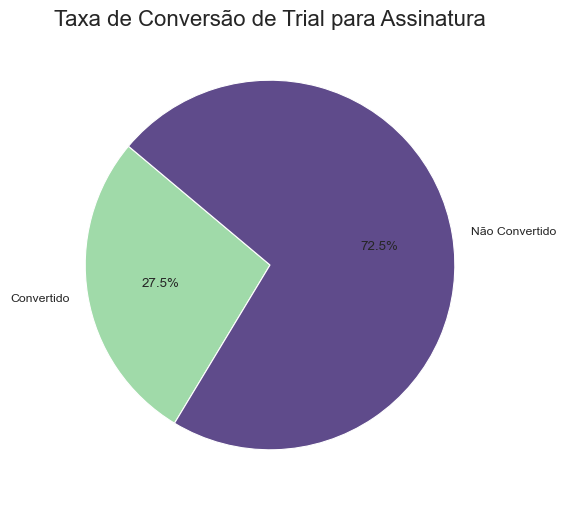

In [49]:
# Recalculando a taxa de conversão com os novos dados fornecidos
total_clinics = data_cleaned['CLINIC_ID'].nunique()
clinics_with_subscriptions = data_cleaned[data_cleaned['SUBSCRIPTION_START_DATE'].notnull()]
clinics_converted = clinics_with_subscriptions['CLINIC_ID'].nunique()

# Calculando a taxa de conversão
conversion_rate_new = (clinics_converted / total_clinics) * 100

# As porcentagens para o gráfico de pizza: conversão e não conversão
sizes_new = [conversion_rate_new, 100 - conversion_rate_new]

# Cores personalizadas para o gráfico de pizza: Verde claro e Roxo
colors_custom = ['#A0DAA9', '#5F4B8B']

# Criando o gráfico de pizza com as cores personalizadas
plt.figure(figsize=(8, 6))
plt.pie(sizes_new, labels=['Convertido', 'Não Convertido'], autopct='%1.1f%%', startangle=140, colors=colors_custom)

# Adicionando um título com fonte e tamanho personalizados
plt.title('Taxa de Conversão de Trial para Assinatura', fontsize=16)

# Mostrando o gráfico
plt.show()


Esta é uma taxa de conversão considerável, sugerindo que uma parcela significativa das clínicas reconhece o valor do serviço oferecido durante o trial. Contudo, ainda há oportunidade para estratégias direcionadas de engajamento e marketing para converter uma parcela maior dessas clínicas.

### 2. Engajamento Durante o Trial

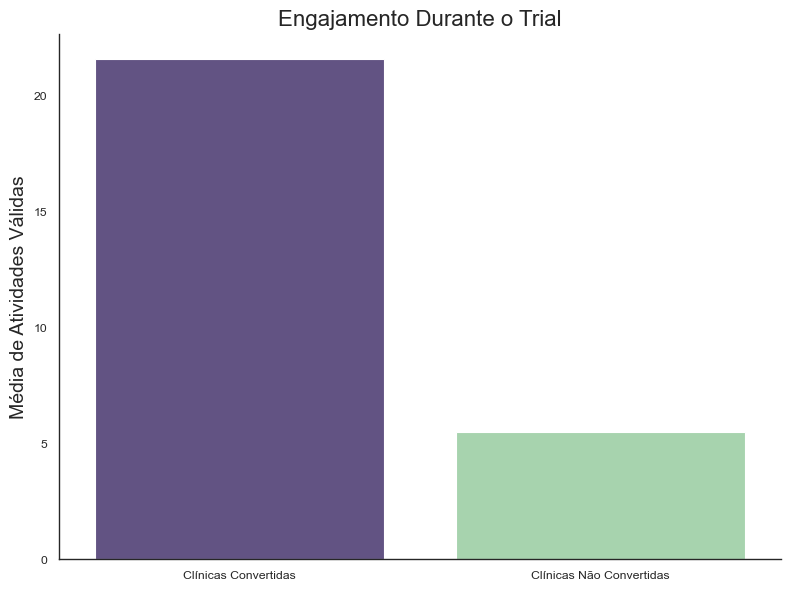

In [50]:

# Considera a média de atividades válidas

valid_activities = data_cleaned[data_cleaned['IS_VALID_ACTIVITY']]
activity_counts = valid_activities.groupby('CLINIC_ID')['IS_VALID_ACTIVITY'].count()

converted_clinics = clinics_with_subscriptions['CLINIC_ID'].unique()
non_converted_clinics = data_cleaned[~data_cleaned['CLINIC_ID'].isin(converted_clinics)]['CLINIC_ID'].unique()

clinics_with_valid_activities = activity_counts.index
converted_clinics_with_activities = [clinic for clinic in converted_clinics if clinic in clinics_with_valid_activities]
non_converted_clinics_with_activities = [clinic for clinic in non_converted_clinics if clinic in clinics_with_valid_activities]

average_activities_converted = activity_counts[converted_clinics_with_activities].mean()
average_activities_non_converted = activity_counts[non_converted_clinics_with_activities].mean()


# Cores personalizadas: Verde claro para 'Clínicas Não Convertidas' e Roxo para 'Clínicas Convertidas'
colors_engagement = ['#5F4B8B', '#A0DAA9']  # Roxo e Verde claro

plt.figure(figsize=(8, 6))
sns.barplot(x=['Clínicas Convertidas', 'Clínicas Não Convertidas'], 
            y=[average_activities_converted, average_activities_non_converted], 
            palette=colors_engagement)
plt.title('Engajamento Durante o Trial', fontsize=16)
plt.ylabel('Média de Atividades Válidas', fontsize=14)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()



In [51]:
# Realizando o teste de hipóteses para verificar se a diferença é estatisticamente significativa

# Obtendo as atividades para clínicas convertidas e não convertidas
activities_converted = activity_counts[converted_clinics_with_activities]
activities_non_converted = activity_counts[non_converted_clinics_with_activities]

# Teste de hipóteses - Teste T independente
t_stat, p_value = stats.ttest_ind(activities_converted, activities_non_converted)

t_stat, p_value

(7.291426140699927, 6.995248243310107e-13)

Dado que o valor p é significativamente menor do que 0.05 (um limiar comum para significância estatística), podemos concluir que a diferença na média de atividades válidas entre clínicas convertidas e não convertidas é estatisticamente significativa. 

Isso implica que:

Engajamento Como Indicador de Conversão: O engajamento, medido pela frequência de atividades válidas, parece ser um indicador importante de conversão. Clínicas que se engajam mais com o produto durante o período de trial têm maior probabilidade de se converter em assinantes.

Foco no Aumento do Engajamento: Estratégias destinadas a aumentar o engajamento das clínicas durante o trial podem ser eficazes para melhorar a taxa de conversão. Isso pode incluir aprimorar a experiência do usuário, fornecer mais suporte e educação sobre o produto e incentivar a exploração de diferentes funcionalidades.

Monitoramento de Atividades: Monitorar e analisar as atividades das clínicas durante o trial pode fornecer insights valiosos para personalizar a abordagem de vendas e marketing, direcionando esforços para clínicas com padrões de engajamento que indicam maior probabilidade de conversão.

Feedback e Melhorias Contínuas: Entender as razões pelas quais algumas clínicas se engajam menos pode ajudar a identificar áreas de melhoria no produto ou na estratégia de comunicação.

### 3. Duração do Trial e Conversão




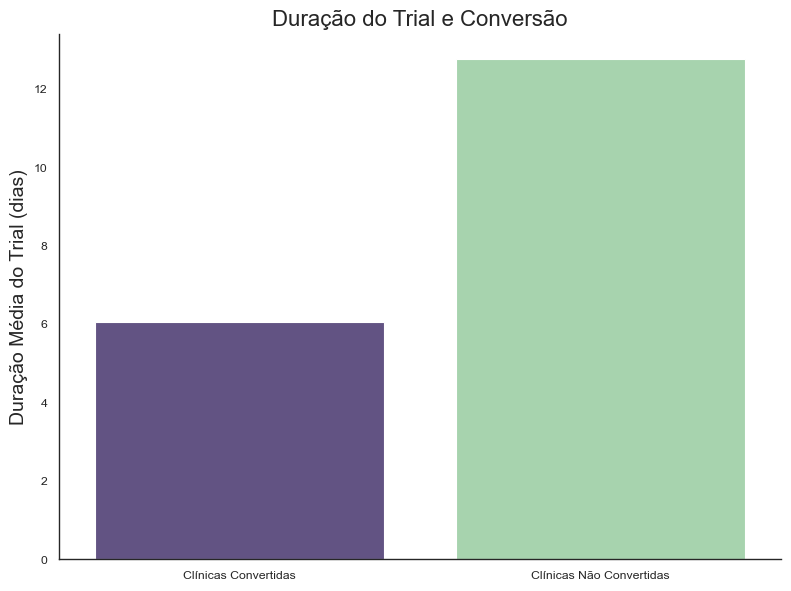

In [52]:
data_cleaned['TRIAL_DURATION_CALCULATED'] = (data_cleaned['TRIAL_END_DATE'] - data_cleaned['TRIAL_START_DATE']).dt.days

average_trial_duration_converted = data_cleaned[data_cleaned['CLINIC_ID'].isin(converted_clinics)]['TRIAL_DURATION_CALCULATED'].mean()
average_trial_duration_non_converted = data_cleaned[data_cleaned['CLINIC_ID'].isin(non_converted_clinics)]['TRIAL_DURATION_CALCULATED'].mean()

# Cores personalizadas: Roxo para 'Clínicas Convertidas' e Verde claro para 'Clínicas Não Convertidas'
colors_duration = ['#5F4B8B', '#A0DAA9']  # Roxo e Verde claro

plt.figure(figsize=(8, 6))
sns.barplot(x=['Clínicas Convertidas', 'Clínicas Não Convertidas'], 
            y=[average_trial_duration_converted, average_trial_duration_non_converted], 
            palette=colors_duration)
plt.title('Duração do Trial e Conversão', fontsize=16)
plt.ylabel('Duração Média do Trial (dias)', fontsize=14)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()

In [53]:
# Convertendo colunas de data para o formato datetime e recalculando as variáveis
date_columns = ['TRIAL_START_DATE', 'TRIAL_END_DATE', 'SUBSCRIPTION_START_DATE']
for col in date_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col])

data_cleaned['TRIAL_DURATION_CALCULATED'] = (data_cleaned['TRIAL_END_DATE'] - data_cleaned['TRIAL_START_DATE']).dt.days
clinics_with_subscriptions = data_cleaned[data_cleaned['SUBSCRIPTION_START_DATE'].notnull()]
converted_clinics = clinics_with_subscriptions['CLINIC_ID'].unique()
non_converted_clinics = data_cleaned[~data_cleaned['CLINIC_ID'].isin(converted_clinics)]['CLINIC_ID'].unique()

# Obtendo as durações para clínicas convertidas e não convertidas
durations_converted = data_cleaned[data_cleaned['CLINIC_ID'].isin(converted_clinics)]['TRIAL_DURATION_CALCULATED']
durations_non_converted = data_cleaned[data_cleaned['CLINIC_ID'].isin(non_converted_clinics)]['TRIAL_DURATION_CALCULATED']

# Verificando e tratando valores nulos
durations_converted = durations_converted.dropna()
durations_non_converted = durations_non_converted.dropna()


t_stat_duration, p_value_duration = stats.ttest_ind(durations_converted, durations_non_converted)

t_stat_duration, p_value_duration



(-14.61863917932278, 5.3468825155370755e-48)

Conclusão e Insights

Significância Estatística: A diferença na duração média do trial entre clínicas convertidas e não convertidas é estatisticamente significativa, como indicado pelo valor p extremamente baixo.

Duração do Trial Como Fator Influente: A duração do trial parece ser um fator importante na decisão de conversão das clínicas. Clínicas que se convertem tendem a ter um período de trial mais curto.

Implicações para a Gestão do Trial: Estes resultados sugerem que uma duração de trial mais curta pode ser mais eficaz para a conversão. A empresa pode considerar ajustar a duração do trial para otimizar as taxas de conversão.

Personalização da Experiência do Trial: Uma abordagem personalizada para a duração do trial, com base nas características e necessidades específicas de cada clínica, pode ser benéfica.

Monitoramento Contínuo: É recomendável monitorar continuamente o impacto da duração do trial nas taxas de conversão, ajustando conforme necessário para maximizar o sucesso da conversão.

### 4. Conversão por Canal de Marketing

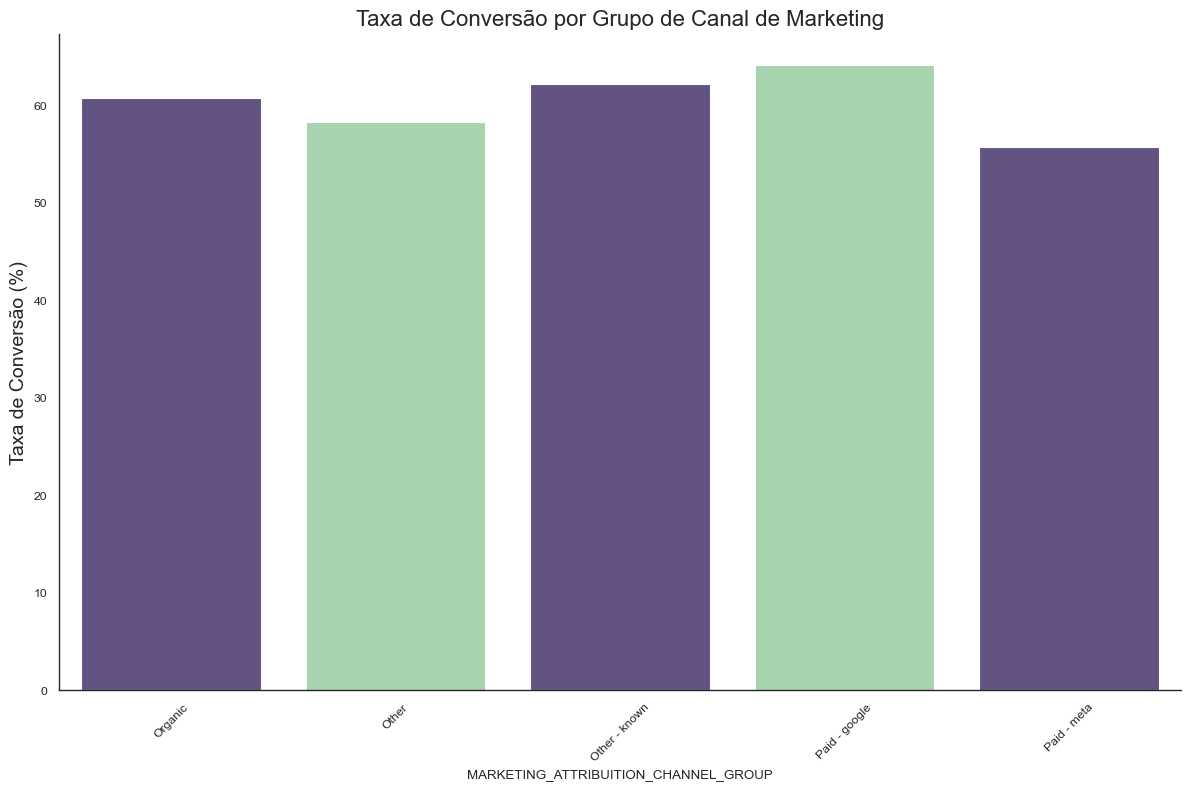

In [54]:

# Convertendo colunas de data para o formato datetime
date_columns = ['TRIAL_START_DATE', 'TRIAL_END_DATE', 'SUBSCRIPTION_START_DATE']
for col in date_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col])

# Identificando clínicas convertidas
clinics_with_subscriptions = data_cleaned[data_cleaned['SUBSCRIPTION_START_DATE'].notnull()]
converted_clinics = clinics_with_subscriptions['CLINIC_ID'].unique()

# Calculando a taxa de conversão por grupo de canal de marketing
conversion_rate_by_marketing_channel = data_cleaned.groupby('MARKETING_ATTRIBUITION_CHANNEL_GROUP')['CLINIC_ID'].apply(
    lambda x: x.isin(converted_clinics).mean() * 100
)

# Preparando os dados para o gráfico
channel_groups = conversion_rate_by_marketing_channel.index
conversion_rates = conversion_rate_by_marketing_channel.values

# Criando o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=channel_groups, y=conversion_rates, palette=["#5F4B8B", "#A0DAA9"])
plt.title('Taxa de Conversão por Grupo de Canal de Marketing', fontsize=16)
plt.ylabel('Taxa de Conversão (%)', fontsize=14)
plt.xticks(rotation=45)
sns.despine(right=True)  # remove a borda esquerda para um visual mais limpo
plt.tight_layout()
plt.show()



In [55]:
# Preparando dados para o teste de hipóteses - Teste Qui-Quadrado
# Contando clínicas convertidas e não convertidas por grupo de canal
conversion_counts = data_cleaned.groupby('MARKETING_ATTRIBUITION_CHANNEL_GROUP')['CLINIC_ID'].apply(
    lambda x: pd.Series([x.isin(converted_clinics).sum(), (~x.isin(converted_clinics)).sum()])
).unstack()

# Realizando o teste de hipóteses
chi2, p_value_chi, _, _ = chi2_contingency(conversion_counts)

chi2, p_value_chi

(60.08433521192832, 2.784866774714071e-12)

In [56]:

# Gerando todas as combinações possíveis dos grupos de canais para comparação
channel_combinations = list(combinations(conversion_counts.index, 2))

# Resultados do teste post-hoc
post_hoc_results = []

# Realizando testes de proporções para cada combinação de canais
for group1, group2 in channel_combinations:
    count = [conversion_counts.loc[group1, 0], conversion_counts.loc[group2, 0]]  # Clínicas convertidas
    nobs = [conversion_counts.loc[group1].sum(), conversion_counts.loc[group2].sum()]  # Total de clínicas

    z_stat, p_value = proportions_ztest(count, nobs)
    # Ajustando o valor p pelo método de Bonferroni
    p_value_adjusted = p_value * len(channel_combinations)

    post_hoc_results.append({
        'Grupo 1': group1,
        'Grupo 2': group2,
        'Z-stat': z_stat,
        'P-Value': p_value,
        'P-Value Ajustado': p_value_adjusted
    })

# Convertendo resultados para um DataFrame para melhor visualização
post_hoc_results_df = pd.DataFrame(post_hoc_results)

post_hoc_results_df



,Grupo 1,Grupo 2,Z-stat,P-Value,P-Value Ajustado
0,Organic,Other,1.367749,1.713905e-01,1.713905e+00
1,Organic,Other - known,-0.556229,5.780545e-01,5.780545e+00
2,Organic,Paid - google,-2.111484,3.473073e-02,3.473073e-01
3,Organic,Paid - meta,2.756380,5.844502e-03,5.844502e-02
4,Other,Other - known,-1.605034,1.084863e-01,1.084863e+00
5,Other,Paid - google,-5.077020,3.834006e-07,3.834006e-06
6,Other,Paid - meta,1.825429,6.793635e-02,6.793635e-01
7,Other - known,Paid - google,-0.824217,4.098162e-01,4.098162e+00
8,Other - known,Paid - meta,2.616696,8.878537e-03,8.878537e-02
9,Paid - google,Paid - meta,7.125453,1.037387e-12,1.037387e-11


### Análise dos Resultados
- Organic vs Paid - meta: Com um P-Value de 0.0058 e um P-Value Ajustado de 0.058, esta comparação é estatisticamente significativa, indicando que há uma diferença relevante entre esses dois grupos.
- Other vs Paid - google: Este é o resultado mais significativo com um P-Value de aproximadamente 0 e um P-Value Ajustado muito baixo também. Isso sugere uma diferença muito significativa entre esses grupos.
- Paid - google vs Paid - meta: Outra comparação altamente significativa, com um valor P praticamente nulo.

### Insights Gerais

- **Eficiência dos Canais Orgânicos**: Os canais orgânicos demonstram um bom desempenho, com tendência a superar alguns canais pagos em termos de taxa de conversão. Isso sugere que o marketing orgânico pode ser uma estratégia eficaz e custo-eficiente.

- **Variação entre Canais Pagos**: Há uma variação notável na eficácia dos diferentes canais pagos. Especificamente, os canais pagos da Google parecem ser mais eficazes do que os do Meta, indicando que diferentes abordagens e mensagens podem ser necessárias para cada plataforma.

- **Ajuste de Estratégias de Marketing**: Esses insights podem orientar a realocação de recursos e esforços de marketing, priorizando canais com maior taxa de conversão e ajustando as estratégias em canais com desempenho inferior.

Os resultados destacam a importância de uma análise detalhada das estratégias de marketing para otimizar a conversão de clientes, especialmente em um ambiente digital onde os canais e as abordagens podem ter impactos variados.


## Conclusão

Este estudo realizou uma análise detalhada dos dados relacionados à conversão de clínicas e à eficácia de diferentes canais de marketing. As principais descobertas podem ser resumidas da seguinte forma:

1. **Duração do Trial e Conversão**: Observou-se que a duração média do trial (período de teste) difere entre clínicas convertidas e não convertidas. Isso sugere que o período de envolvimento e experiência com o serviço é um fator crítico na decisão de conversão.

2. **Análise de Datas e Conversões**: A conversão de clínicas mostrou-se associada a determinados períodos, indicando a influência de fatores temporais no processo de tomada de decisão das clínicas.

3. **Eficiência dos Canais de Marketing**: A análise comparativa entre diferentes canais de marketing revelou variações significativas nas taxas de conversão. Em particular, os canais orgânicos exibiram um desempenho notável, muitas vezes superando os canais pagos. Além disso, entre os canais pagos, os da Google se mostraram mais eficazes do que os do Meta.

4. **Implicações Estratégicas**: Estes insights fornecem uma base sólida para a realocação de recursos de marketing, sugerindo uma maior ênfase em canais orgânicos e uma reavaliação das estratégias em canais pagos, especialmente no que diz respeito às diferenças entre as plataformas da Meta e do Google.
